In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 52.0 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
import numpy as np
import re
import ast
import spacy
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
# Инициализация
nlp = spacy.load("en_core_web_sm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Предобработка данных

In [4]:
def load_preprocessed_data():
    resume_path = f'/content/resume_processed.parquet'
    vacancy_path = f'/content/vacancy_processed.parquet'

    if os.path.exists(resume_path) and os.path.exists(vacancy_path):
        resume_df = pd.read_parquet(resume_path)
        vacancy_df = pd.read_parquet(vacancy_path)
        print("Данные успешно загружены")
        return resume_df, vacancy_df
    else:
        print("Предобработанные файлы не найдены")
        return None, None

resume_df, vacancy_df = load_preprocessed_data()

Данные успешно загружены


In [ ]:
# --------------------------------------------------
# Загрузка и предобработка данных
# --------------------------------------------------

def safe_literal_eval(s):
    try:
        return ast.literal_eval(s) if pd.notna(s) else []
    except (ValueError, SyntaxError):
        return []

def load_data():
    # Загружаем резюме
    resume_df = pd.read_csv('/content/Resume.csv')
    # Загрузка вакансий
    vacancy_df = pd.read_csv("/content/resume_data.csv")
    vacancy_df.columns = [col.strip('\ufeff') for col in vacancy_df.columns]
    return resume_df, vacancy_df

resume_df, vacancy_df = load_data()

# Предобработка резюме
def preprocess_resume(text):
    garbage_skills = {
        '', 'nan', 'Etc', 'Other', 'Various', 'And', 'Or', 'Including',
        'City', 'Company Name', 'Education', 'Experience', 'Current',
        'Bachelor', 'Skills', 'Accomplishments', 'Developed', 'Highlights',
        'State', 'Excellent', 'Created', 'Assisted', 'Arts', 'Additional Information',
        'Associate', 'Business', 'Customer', 'August', 'Ability', 'Maintained',
        'Managed', 'Conducted', 'Coordinated', 'Director', 'Certifications',
        'May', 'GPA', 'April', 'December', 'Assist', 'Core Qualifications',
        'Client', 'January', 'Designed', 'High School Diploma', 'Financial',
        'Summary', 'Completed', 'Highly', 'Exceptional', 'Collaborated',
        'Established', 'Demonstrated', 'Consistently', 'Extensive', 'Experienced',
        'Advanced', 'Ensured', 'Create', 'Analyzed', 'June'
    }

    # Базовая очистка текста
    text = str(text).replace('\n', ' ').replace('\t', ' ')
    doc = nlp(text[:100000])  # Ограничиваем размер для обработки

    # Инициализация компонентов
    components = {
        '[SUMMARY]': text[:300],
        '[EXPERIENCE]': [],
        '[EDUCATION]': [],
        '[SKILLS]': [],
    }

    # 1. Извлечение навыков
    skills = set()

    # Ищем явный раздел Skills
    skills_section_match = re.search(
        r'(?i)(?:skills|competencies|expertise|technical skills|qualifications)[:\s\-]*\s*(.*?)(?=(?:experience|education|work history|employment|projects|$))',
        text
    )

    if skills_section_match:
        skills_section = skills_section_match.group(1)
        # Извлекаем навыки из раздела (разделители: запятые, точки с запятой, переносы строк)
        section_skills = re.findall(r'([A-Za-z][A-Za-z/\-\.\s]+(?: [A-Za-z][A-Za-z/\-\.\s]+)*)', skills_section)
        skills.update(
            skill.strip() for skill in section_skills
            if (2 < len(skill.strip()) < 50 and skill.strip() not in garbage_skills)
        )

    # Дополнительно используем NER для извлечения
    for ent in doc.ents:
        if ent.label_ == 'SKILL' and ent.text not in garbage_skills:
            skills.add(ent.text)

    # Ищем навыки в маркированных списках
    bullet_points = re.split(r'[\n•\-*]\s*', text)
    for point in bullet_points:
        if any(keyword in point.lower() for keyword in ['skill', 'proficient', 'expert', 'knowledge']):
            extracted_skills = re.findall(r'([A-Z][A-Za-z/\-]+(?: [A-Z][A-Za-z/\-]+)*)', point)
            skills.update(
                skill for skill in extracted_skills
                if skill not in garbage_skills
            )

    if skills:
        # Дополнительная фильтрация и сортировка навыков
        filtered_skills = [
            skill for skill in skills
            if (len(skill) > 2
                and not any(char.isdigit() for char in skill)
                and skill not in garbage_skills)
        ]
        components['[SKILLS]'] = ' | '.join(sorted(filtered_skills))[:500]

    # 2. Извлечение опыта работы
    experience = []
    for ent in doc.ents:
        if ent.label_ in ('ORG', 'DATE') and 'experience' in ent.sent.text.lower():
            experience.append(ent.text)
    if experience:
        components['[EXPERIENCE]'] = ' | '.join(experience)

    # 3. Извлечение образования
    education_keywords = ['university', 'college', 'institute', 'bachelor', 'master', 'phd']
    education = []
    for sent in doc.sents:
        if any(keyword in sent.text.lower() for keyword in education_keywords):
            education.append(sent.text.strip())
    if education:
        components['[EDUCATION]'] = ' | '.join(education)[:500]

    # Собираем итоговый текст
    processed_parts = []
    for tag, content in components.items():
        if content and (isinstance(content, str) and content.strip() or isinstance(content, list) and content):
            if isinstance(content, list):
                content = ' | '.join(content)
            processed_parts.append(f"{tag} {content.strip()}")

    processed_text = '\n'.join(processed_parts)[:3000]
    return re.sub(r'\s+', ' ', processed_text).strip()

resume_df['processed_text'] = resume_df['Resume_str'].apply(preprocess_resume)

# Предобработка вакансий
def preprocess_vacancy(row):

    def get_safe_str(value):
        return str(value) if pd.notna(value) else ''

    def get_safe_list(value):
        try:
            lst = safe_literal_eval(value) if pd.notna(value) else []
            return [str(x) for x in lst] if isinstance(lst, list) else []
        except:
            return []

    # Обработка навыков - объединяем все источники и разделяем через |
    skills = list(set(
        get_safe_list(row.get('skills')) +
        get_safe_list(row.get('skills_required')) +
        [str(x) for sublist in get_safe_list(row.get('related_skils_in_job'))
         for x in (sublist if isinstance(sublist, list) else [sublist])]
    ))
    skills_str = ' | '.join(skills) if skills else ''

    # Формирование компонентов
    components = []

    # 1. Позиция
    if position := get_safe_str(row.get('job_position_name')):
        components.append(f"[POSITION] {position}")

    # 2. Образование
    education_parts = [
        get_safe_str(row.get('educationaL_requirements')),
        ' '.join(get_safe_list(row.get('degree_names')))
    ]
    if education := ' '.join(filter(None, education_parts)):
        components.append(f"[EDUCATION] {education}")

    # 3. Опыт
    if experience := get_safe_str(row.get('experiencere_requirement')):
        components.append(f"[EXPERIENCE] {experience}")

    # 4. Навыки
    if skills_str:
        components.append(f"[SKILLS] {skills_str}")

    # 5. Обязанности
    if responsibilities := ' '.join(filter(None, [
        get_safe_str(row.get('responsibilities')),
        get_safe_str(row.get('responsibilities.1'))
    ])):
        components.append(f"[RESPONSIBILITIES] {responsibilities}")

    # 6. Цель
    if career_goal := get_safe_str(row.get('career_objective')):
        components.append(f"[CAREER_GOAL] {career_goal}")

    # Собираем итоговый текст
    processed_text = '\n'.join(components)[:3000]
    return re.sub(r'\s+', ' ', processed_text).strip()

vacancy_df['processed_text'] = vacancy_df.apply(preprocess_vacancy, axis=1)

In [ ]:
# Сохранение
PREPROCESSED_PATH = '/content/'
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

def save_preprocessed_data(resume_df, vacancy_df):
    resume_df.to_parquet(f'{PREPROCESSED_PATH}resume_processed.parquet', engine='pyarrow')
    vacancy_df.to_parquet(f'{PREPROCESSED_PATH}vacancy_processed.parquet', engine='pyarrow')
    print("Данные успешно сохранены")

save_preprocessed_data(resume_df, vacancy_df)

Данные успешно сохранены


In [ ]:
vacancy_df['processed_text'][0]

"[POSITION] Senior Software Engineer [EDUCATION] B.Sc in Computer Science & Engineering from a reputed university. B.Tech [EXPERIENCE] At least 1 year [SKILLS] Amazon Redshift | Informatica | Core Java | RDBMS | Mapreduce | DBMS | Hive | Hadoop | Spark | ['Big Data'] | YARN | Python | Machine Learning | Java | Data Structures | Big Data | Hdfs | C++ | Microsoft Azure | Cloud | Talend | Data Science [RESPONSIBILITIES] Technical Support Troubleshooting Collaboration Documentation System Monitoring Software Deployment Training & Mentorship Industry Trends Field Visits Technical Support Troubleshooting Collaboration Documentation System Monitoring Software Deployment Training & Mentorship Industry Trends Field Visits [CAREER_GOAL] Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud infrastructure services and am well acquainted with them. Currently in search of role that offers more of development."

In [ ]:
resume_df['processed_text'][1]

'[SUMMARY] HR SPECIALIST, US HR OPERATIONS Summary Versatile media professional with background in Communications, Marketing, Human Resources and Technology. Experience 09/2015 to Current HR Specialist, US HR Operations Company Name － City , State Managed [EXPERIENCE] Operations Company Name | Operations [EDUCATION] Education 2014 Master of Arts : Corporate Communication & Public Relations Sacred Heart University － City , State 2013 Bachelor of Arts : Relational Communication Western Connecticut State University － City , State Skills Adobe Photoshop, ADP, Asset Management, branding, brochures, content, Customer Care, Final Cut Pro, graphics, graphic, HR, Illustrator, InDesign, Innovation, inventory, Lotus Notes, marketing, marketing materials [SKILLS] ADP | ATM | Adobe Photoshop | Asset Management | Assistant Head Teller | Coached | Corporate Communication | Customer Care | Educated | Employee Development | Final Cut Pro | Illustrator | Implemented | Improved | InDesign | Innovation | 

# Генерация пар

In [5]:
# Загрузка
def load_preprocessed_data():
    pair_path = f'/content/pairs_df.parquet'

    if os.path.exists(pair_path):
        pairs_df = pd.read_parquet(pair_path)
        print("Данные успешно загружены")
        return pairs_df
    else:
        print("Файлы не найдены")
        return None, None

pairs_df = load_preprocessed_data()

Данные успешно загружены


In [ ]:
# Пути для сохранения
PREPROCESSED_PATH = '/content/'
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

# Функция сохранения
def save_preprocessed_data(pairs_df):
    pairs_df.to_parquet(f'{PREPROCESSED_PATH}pairs_df.parquet', engine='pyarrow')
    print("Данные успешно сохранены")

save_preprocessed_data(pairs_df)

Данные успешно сохранены


In [ ]:
encoder = SentenceTransformer('all-MiniLM-L6-v2').to(device)
resume_embeddings = encoder.encode(resume_df['processed_text'].tolist(), show_progress_bar=True)
vacancy_embeddings = encoder.encode(vacancy_df['processed_text'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
# --------------------------------------------------
# Генерация обучающих пар
# --------------------------------------------------

# Инициализация семантического поиска
encoder = SentenceTransformer('all-MiniLM-L6-v2').to(device)
resume_embeddings = encoder.encode(resume_df['processed_text'].tolist(), show_progress_bar=True)
vacancy_embeddings = encoder.encode(vacancy_df['processed_text'].tolist(), show_progress_bar=True)

def generate_pairs(resume_embeddings, vacancy_embeddings, k_pos=4, k_neg=4, k_hard_neg=2):
    pairs = []

    # Создаем индекс для вакансий
    vacancy_index = faiss.IndexFlatIP(resume_embeddings.shape[1])
    vacancy_index.add(vacancy_embeddings)

    # Создаем индекс для резюме
    resume_index = faiss.IndexFlatIP(resume_embeddings.shape[1])
    resume_index.add(resume_embeddings)

    for i, res_emb in enumerate(tqdm(resume_embeddings)):
        # 1. Положительные пары (семантически близкие вакансии)
        _, pos_indices = vacancy_index.search(np.array([res_emb]), k=k_pos + 5)
        pos_indices = [idx for idx in pos_indices[0] if idx < len(vacancy_embeddings)][:k_pos]

        # 2. Hard negatives (похожие, но не топовые вакансии)
        _, hard_neg_indices = vacancy_index.search(np.array([res_emb]), k=k_pos + k_hard_neg + 5)
        hard_neg_indices = [idx for idx in hard_neg_indices[0]
                           if idx not in pos_indices and idx < len(vacancy_embeddings)][:k_hard_neg]

        # 3. Случайные негативы из другой профессиональной области
        other_profession_indices = find_different_profession(
            i, resume_embeddings, vacancy_embeddings, k_neg, resume_index, vacancy_index
        )

        # Формируем все пары
        pairs.extend([(i, int(j), 1.0) for j in pos_indices])
        pairs.extend([(i, int(j), 0.0) for j in hard_neg_indices])
        pairs.extend([(i, int(j), 0.0) for j in other_profession_indices])

    return pd.DataFrame(pairs, columns=['resume_idx', 'vacancy_idx', 'label'])

def find_different_profession(resume_idx, resume_embeddings, vacancy_embeddings, k, resume_index, vacancy_index):
    # Находим ближайшие резюме к текущему
    _, similar_resumes = resume_index.search(resume_embeddings[resume_idx:resume_idx+1], 10)

    # Собираем все вакансии, подходящие этим резюме
    positive_vacancies = set()
    for r_idx in similar_resumes[0]:
        if r_idx < len(resume_embeddings):
            _, vac_indices = vacancy_index.search(resume_embeddings[r_idx:r_idx+1], 20)
            positive_vacancies.update(vac_indices[0])

    # Создаем пул возможных негативов (все вакансии минус позитивные)
    all_indices = set(range(len(vacancy_embeddings)))
    negative_pool = list(all_indices - positive_vacancies)

    # Возвращаем k случайных из оставшихся
    return np.random.choice(negative_pool, size=min(k, len(negative_pool)), replace=False) if negative_pool else []

pairs_df = generate_pairs(resume_embeddings, vacancy_embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

100%|██████████| 2484/2484 [00:43<00:00, 57.34it/s]


In [ ]:
pairs_df.iloc[0:15]

,resume_idx,vacancy_idx,label
0,0,5214,1.0
1,0,949,1.0
2,0,3126,1.0
3,0,1743,1.0
4,0,1496,0.0
5,0,7145,0.0
6,0,3053,0.0
7,0,5210,0.0
8,0,6631,0.0
9,0,5221,0.0


# Анализ данных

In [6]:
def analyze_data(resume_df, vacancy_df, pairs_df):

    # Словарь синонимов навыков (каноническая форма: [варианты])
    SKILL_SYNONYMS = {
        'excel': ['excel', 'microsoft excel', 'ms excel'],
        'python': ['python', 'python 3', 'python3', 'python programming'],
        'java': ['java', 'java 8', 'core java', 'java programming'],
        'machine learning': ['ml', 'machine learning', 'machine-learning'],
        'sql': ['sql', 'mysql', 'postgresql', 'sql server', 'SQL'],
        'javascript': ['js', 'javascript', 'ecmascript'],
        'tableau': ['tableau', 'tableau desktop', 'tableau software'],
        'power bi': ['power bi', 'powerbi', 'microsoft power bi'],
        'c++': ['c++', 'cpp', 'c plus plus'],
        'project management': ['pm', 'project mgmt', 'project management']
    }

    # Создаем инвертированный словарь для быстрого поиска
    SYNONYM_MAP = {}
    for main_skill, variants in SKILL_SYNONYMS.items():
        for variant in variants:
            SYNONYM_MAP[variant] = main_skill

    # Функция нормализации навыков
    def normalize_skill(skill):
        if not isinstance(skill, str):
            return None

        skill = skill.lower().strip()

        # Проверяем полные совпадения
        if skill in SYNONYM_MAP:
            return SYNONYM_MAP[skill]

        # Проверяем частичные совпадения
        for variant, main in SYNONYM_MAP.items():
            if variant in skill or skill in variant:
                return main

        return skill

    # Функция извлечения навыков из текста
    def extract_skills(text):

        if pd.isna(text):
            return []

        # Ищем блок с навыками
        match = re.search(r'\[SKILLS\](.*?)(?=\[|$)', text, re.IGNORECASE)
        if not match:
            return []

        skills_text = match.group(1)
        # Разбиваем по разделителям (| или ,)
        skills = re.split(r'[|,]', skills_text)

        # Нормализуем каждый навык и фильтруем None
        normalized_skills = []
        for skill in skills:
            skill = skill.strip()
            if len(skill) > 2:  # Игнорируем слишком короткие
                normalized = normalize_skill(skill)
                if normalized and normalized.lower() != 'none':  # Явная фильтрация
                    normalized_skills.append(normalized)

        return normalized_skills

    # 1. Визуализация распределения длин текстов
    plt.figure(figsize=(12, 6))
    sns.histplot(resume_df['processed_text'].str.len(), bins=50,
                color='blue', alpha=0.5, label='Резюме')
    sns.histplot(vacancy_df['processed_text'].str.len(), bins=50,
                color='red', alpha=0.5, label='Вакансии')
    plt.title('Распределение длины текстов')
    plt.legend()
    plt.show()

    # 2. Анализ баланса классов
    plt.figure(figsize=(8, 6))
    class_counts = pairs_df['label'].value_counts()
    plt.pie(class_counts, labels=['Негативные', 'Позитивные'],
           autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title('Соотношение классов в парах')
    plt.show()

    try:
        # Анализ навыков в резюме
        all_resume_skills = []
        for text in resume_df['processed_text']:
            all_resume_skills.extend(extract_skills(text))

        resume_skill_counts = pd.Series(all_resume_skills).value_counts().head(30)

        # Анализ навыков в вакансиях
        all_vacancy_skills = []
        for text in vacancy_df['processed_text']:
            skills = extract_skills(text)
            all_vacancy_skills.extend([s for s in skills if s is not None])

        vacancy_skill_counts = pd.Series(all_vacancy_skills).value_counts().head(30)

        # 3. Визуализация топ-30 навыков
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)
        resume_skill_counts.plot(kind='barh', color='skyblue')
        plt.title('Топ-30 навыков в резюме')
        plt.xlabel('Частота')
        plt.gca().invert_yaxis()

        plt.subplot(1, 2, 2)
        vacancy_skill_counts.plot(kind='barh', color='lightcoral')
        plt.title('Топ-30 требуемых навыков')
        plt.xlabel('Частота')
        plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.show()

        # 4. Сравнение навыков с учетом синонимов
        resume_top = set(resume_skill_counts.index)
        vacancy_top = set(vacancy_skill_counts.index)
        common_skills = resume_top.intersection(vacancy_top)

        print("\n=== Сравнение топ-30 навыков ===")
        if common_skills:
            print("Общие навыки:")
            for skill in sorted(common_skills,
                              key=lambda x: resume_skill_counts[x] + vacancy_skill_counts[x],
                              reverse=True):
                print(f"- {skill} (резюме: {resume_skill_counts[skill]}, вакансии: {vacancy_skill_counts[skill]})")
        else:
            print("Прямых совпадений не найдено. Анализ возможных соответствий...")

            # Поиск похожих навыков
            from difflib import get_close_matches
            potential_matches = []

            for r_skill in resume_skill_counts.index:
                matches = get_close_matches(r_skill, vacancy_skill_counts.index, n=1, cutoff=0.7)
                if matches:
                    potential_matches.append((r_skill, matches[0]))

            if potential_matches:
                print("\nВозможные соответствия:")
                for r_skill, v_skill in potential_matches:
                    print(f"- '{r_skill}' (резюме) ~ '{v_skill}' (вакансии)")
                    print(f"  Рекомендуется добавить в синонимы: '{r_skill}': ['{v_skill}']")
            else:
                print("Не найдено даже близких соответствий")

        # Вывод статистики
        print("\n=== Общая статистика ===")
        print(f"Всего резюме: {len(resume_df)}")
        print(f"Всего вакансий: {len(vacancy_df)}")
        print(f"Всего пар: {len(pairs_df)}")
        # Длины текстов
        resume_lens = resume_df['processed_text'].str.len()
        vacancy_lens = vacancy_df['processed_text'].str.len()
        print(f"Средняя длина резюме: {resume_lens.mean():.0f} ± {resume_lens.std():.0f} символов")
        print(f"Средняя длина вакансий: {vacancy_lens.mean():.0f} ± {vacancy_lens.std():.0f} символов")

        # Дисбаланс классов
        class_counts = pairs_df['label'].value_counts()
        print(f"\nДисбаланс классов:")
        print(f"- Позитивные пары: {class_counts.get(1.0, 0)} ({class_counts.get(1.0, 0)/len(pairs_df)*100:.1f}%)")
        print(f"- Негативные пары: {class_counts.get(0.0, 0)} ({class_counts.get(0.0, 0)/len(pairs_df)*100:.1f}%)")

    except Exception as e:
        print(f"Ошибка при анализе навыков: {str(e)}")
        import traceback
        traceback.print_exc()

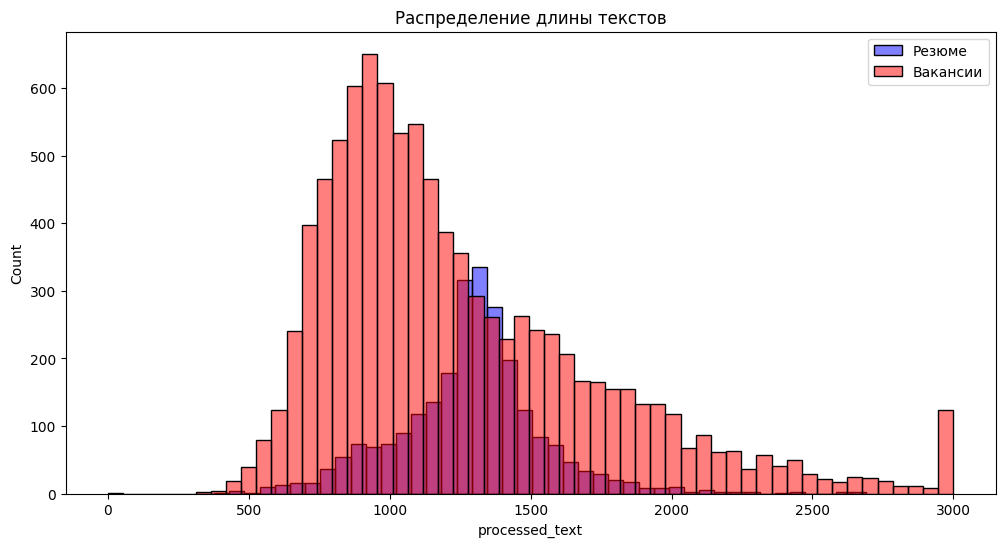

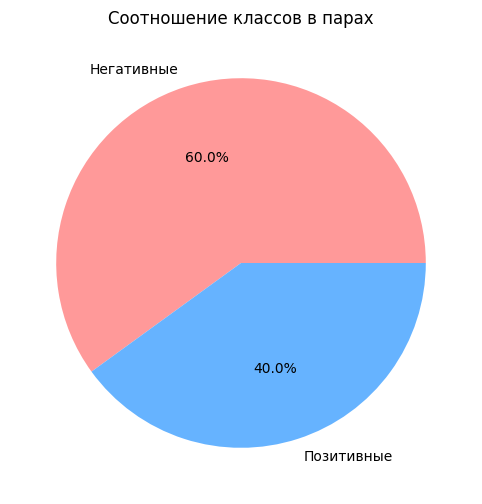

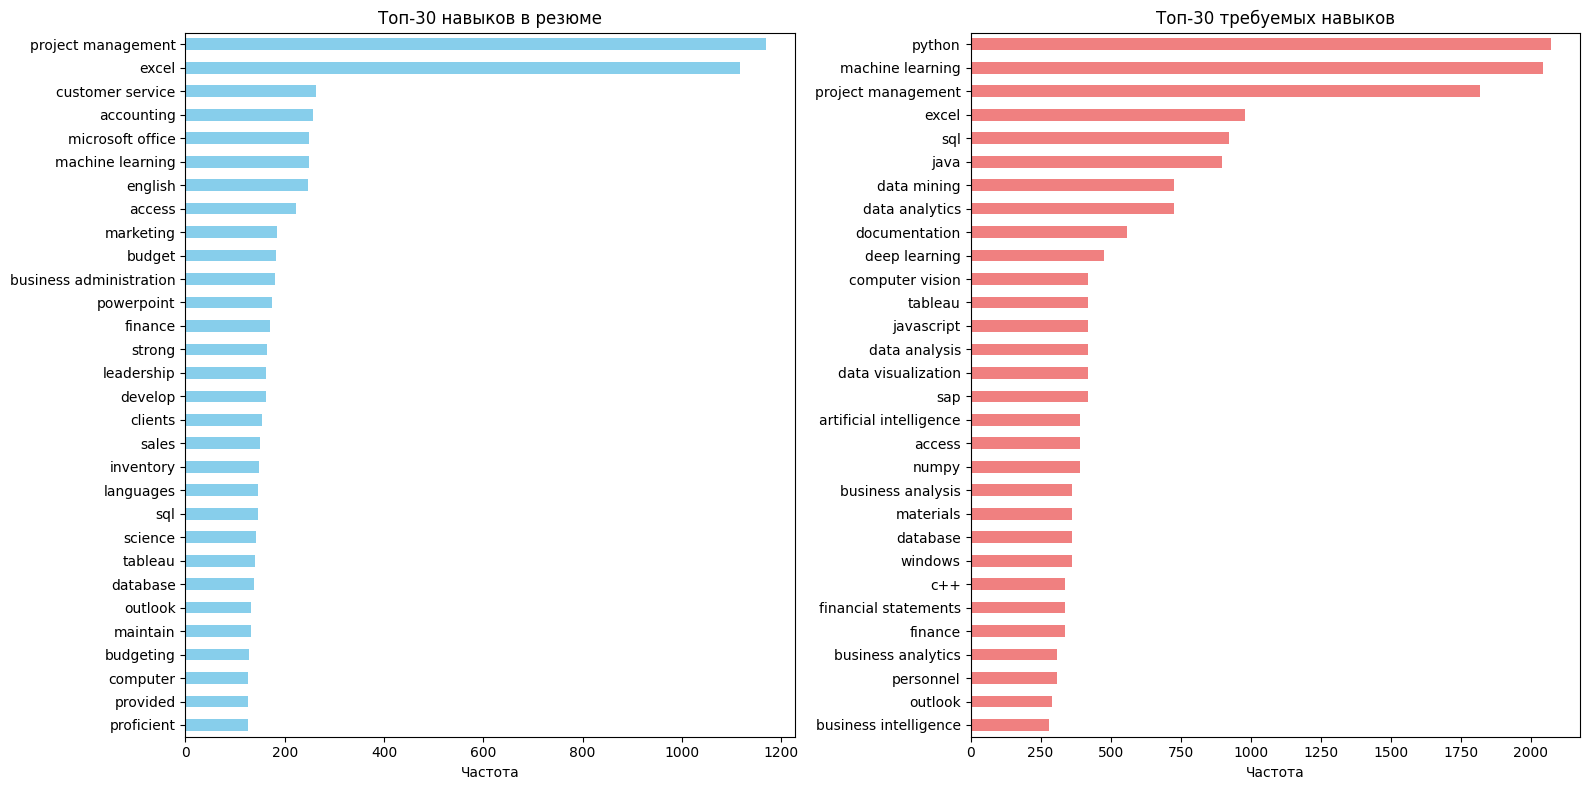


=== Сравнение топ-30 навыков ===
Общие навыки:
- project management (резюме: 1169, вакансии: 1820)
- machine learning (резюме: 250, вакансии: 2044)
- excel (резюме: 1117, вакансии: 980)
- sql (резюме: 146, вакансии: 924)
- access (резюме: 223, вакансии: 392)
- tableau (резюме: 141, вакансии: 420)
- finance (резюме: 170, вакансии: 336)
- database (резюме: 138, вакансии: 364)
- outlook (резюме: 132, вакансии: 290)

=== Общая статистика ===
Всего резюме: 2484
Всего вакансий: 9544
Всего пар: 24840
Средняя длина резюме: 1285 ± 264 символов
Средняя длина вакансий: 1250 ± 498 символов

Дисбаланс классов:
- Позитивные пары: 9936 (40.0%)
- Негативные пары: 14904 (60.0%)


In [7]:
analyze_data(resume_df, vacancy_df, pairs_df)

# DistilBERT

In [ ]:
from transformers import AutoModel

class Distil(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 1. DistilBERT-энкодер
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        self.embedding_dim = self.bert.config.hidden_size  # 768

        # Замораживаем все слои кроме последних двух
        for param in self.bert.parameters():
            param.requires_grad = False
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # 2. Проекционные слои
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 512),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Linear(512, 256),
            torch.nn.Dropout(0.3)
        )

        # 3. Классификатор
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256*3, 128),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1)
        )

    def forward(self, resume_input, vacancy_input):
        # Получаем эмбеддинги из BERT
        resume_outputs = self.bert(**resume_input)
        resume_emb = resume_outputs.last_hidden_state[:, 0]  # Берем первый [CLS] токен

        vacancy_outputs = self.bert(**vacancy_input)
        vacancy_emb = vacancy_outputs.last_hidden_state[:, 0]  # Берем первый [CLS] токен

        # Проекции
        resume_proj = self.projection(resume_emb)
        vacancy_proj = self.projection(vacancy_emb)

        # Комбинируем признаки
        combined = torch.cat([
            resume_proj,
            vacancy_proj,
            (resume_proj - vacancy_proj).abs()
        ], dim=1)

        return self.classifier(combined).squeeze(1)

# DistilBERT + Max pooling

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class DistilMax(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        self.embedding_dim = self.bert.config.hidden_size  # 768

        # Заморозка всех слоёв кроме последних двух
        for param in self.bert.parameters():
            param.requires_grad = False
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Проекционные слои
        self.projection = nn.Sequential(
            nn.Linear(self.embedding_dim, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.Dropout(0.3)
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, resume_input, vacancy_input):
        resume_outputs = self.bert(**resume_input)
        resume_embeds = resume_outputs.last_hidden_state  # (batch, seq_len, hidden_dim)
        resume_emb = torch.max(resume_embeds, dim=1).values  # max pooling по seq_len

        vacancy_outputs = self.bert(**vacancy_input)
        vacancy_embeds = vacancy_outputs.last_hidden_state
        vacancy_emb = torch.max(vacancy_embeds, dim=1).values  # max pooling

        resume_proj = self.projection(resume_emb)
        vacancy_proj = self.projection(vacancy_emb)

        combined = torch.cat([
            resume_proj,
            vacancy_proj,
            (resume_proj - vacancy_proj).abs()
        ], dim=1)

        return self.classifier(combined).squeeze(1)


# DistilBERT + BiLSTM

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class DistilLSTM(nn.Module):
    def __init__(self, lstm_hidden_size=256, lstm_num_layers=1, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        self.embedding_dim = self.bert.config.hidden_size

        # Заморозка всех слоёв кроме последних двух
        for param in self.bert.parameters():
            param.requires_grad = False
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # BiLSTM поверх эмбеддингов DistilBERT
        self.bilstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_num_layers > 1 else 0
        )

        # Проекционные слои
        self.projection = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.Dropout(dropout)
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3, 128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, resume_input, vacancy_input):
        # Получаем эмбеддинги DistilBERT (batch, seq_len, hidden_dim)
        resume_outputs = self.bert(**resume_input)
        resume_embeds = resume_outputs.last_hidden_state

        vacancy_outputs = self.bert(**vacancy_input)
        vacancy_embeds = vacancy_outputs.last_hidden_state

        # Пропускаем через BiLSTM
        resume_lstm_out, _ = self.bilstm(resume_embeds)  # (batch, seq_len, 2*lstm_hidden_size)
        vacancy_lstm_out, _ = self.bilstm(vacancy_embeds)

        # Аггрегация по seq_len (max pooling)
        resume_repr, _ = torch.max(resume_lstm_out, dim=1)
        vacancy_repr, _ = torch.max(vacancy_lstm_out, dim=1)

        # Проекции
        resume_proj = self.projection(resume_repr)
        vacancy_proj = self.projection(vacancy_repr)

        # Комбинация признаков
        combined = torch.cat([
            resume_proj,
            vacancy_proj,
            (resume_proj - vacancy_proj).abs()
        ], dim=1)

        return self.classifier(combined).squeeze(1)


# DistilBERT + CrossAttention

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel

class DistilAtt(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
        self.embedding_dim = self.bert.config.hidden_size

        for param in self.bert.parameters():
            param.requires_grad = False
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.attention = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.embedding_dim, self.embedding_dim),
            torch.nn.Tanh(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.embedding_dim, 1, bias=False)
        )

        # Слой cross-attention
        self.cross_attention = torch.nn.MultiheadAttention(
            embed_dim=self.embedding_dim, num_heads=4, dropout=0.3
        )

        self.projection = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 512),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Linear(512, 256),
            torch.nn.Dropout(0.3)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 5, 128),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1)
        )

    def _apply_attention(self, embeddings, attention_mask=None):
        attention_scores = self.attention(embeddings).squeeze(-1)
        if attention_mask is not None:
            attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=1)
        weighted = (embeddings * attention_weights.unsqueeze(-1))
        return weighted.sum(dim=1)

    def _apply_cross_attention(self, query, key, value, key_padding_mask=None):
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        attn_output, _ = self.cross_attention(
            query, key, value, key_padding_mask=key_padding_mask
        )
        attn_output = attn_output.transpose(0, 1)
        return attn_output.mean(dim=1)

    def forward(self, resume_input, vacancy_input):
        resume_outputs = self.bert(**resume_input)
        resume_embeddings = resume_outputs.last_hidden_state
        vacancy_outputs = self.bert(**vacancy_input)
        vacancy_embeddings = vacancy_outputs.last_hidden_state

        resume_mask = resume_input.get('attention_mask', None)
        vacancy_mask = vacancy_input.get('attention_mask', None)

        resume_emb = self._apply_attention(resume_embeddings, resume_mask)
        vacancy_emb = self._apply_attention(vacancy_embeddings, vacancy_mask)

        # Cross-attention: резюме смотрит на вакансию и наоборот
        resume_cross = self._apply_cross_attention(
            resume_embeddings, vacancy_embeddings, vacancy_embeddings,
            key_padding_mask=~vacancy_mask.bool() if vacancy_mask is not None else None
        )
        vacancy_cross = self._apply_cross_attention(
            vacancy_embeddings, resume_embeddings, resume_embeddings,
            key_padding_mask=~resume_mask.bool() if resume_mask is not None else None
        )

        resume_proj = self.projection(resume_emb)
        vacancy_proj = self.projection(vacancy_emb)
        resume_cross_proj = self.projection(resume_cross)
        vacancy_cross_proj = self.projection(vacancy_cross)

        combined = torch.cat([
            resume_proj,
            vacancy_proj,
            (resume_proj - vacancy_proj).abs(),
            resume_cross_proj,
            vacancy_cross_proj
        ], dim=1)

        output = self.classifier(combined)
        return output.squeeze(1)


# Классы и функции для обучения

In [ ]:
from sklearn.metrics import ndcg_score, label_ranking_average_precision_score, accuracy_score
import torch.nn.functional as F

# --------------------------------------------------
# Подготовка DataLoader
# --------------------------------------------------
class MatchingDataset(Dataset):
    def __init__(self, pairs_df, resume_df, vacancy_df, tokenizer, max_length=256):
        self.pairs = pairs_df
        self.resume_texts = resume_df['processed_text'].values
        self.vacancy_texts = vacancy_df['processed_text'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        return {
            'resume_text': self.resume_texts[int(pair['resume_idx'])],
            'vacancy_text': self.vacancy_texts[int(pair['vacancy_idx'])],
            'label': float(pair['label'])
        }

In [ ]:
# --------------------------------------------------
# Функции для обучения модели
# --------------------------------------------------
from torch.amp import autocast, GradScaler

def calculate_ranking_metrics(scores, labels):
    scores = np.array(scores)
    labels = np.array(labels)

    # Батчи по 10 элементов для метрик
    n_batches = len(scores) // 10
    batch_scores = [scores[i*10:(i+1)*10] for i in range(n_batches)]
    batch_labels = [labels[i*10:(i+1)*10] for i in range(n_batches)]

    metrics = {
        'ndcg': np.mean([ndcg_score([bl], [bs]) for bs, bl in zip(batch_scores, batch_labels)]) if n_batches > 0 else 0,
        'lrap': label_ranking_average_precision_score(batch_labels, batch_scores) if n_batches > 0 else 0
    }
    return metrics

In [ ]:
from sklearn.model_selection import train_test_split

def collate_fn(batch, tokenizer, max_length=256):
    resume_texts = [item['resume_text'] for item in batch]
    vacancy_texts = [item['vacancy_text'] for item in batch]

    inputs = {
        'resume': tokenizer(
            resume_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt',
            add_special_tokens=True,
            return_token_type_ids=False
        ),
        'vacancy': tokenizer(
            vacancy_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt',
            add_special_tokens=True,
            return_token_type_ids=False
        ),
        'labels': torch.tensor([item['label'] for item in batch], dtype=torch.float)
    }
    return inputs

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_scores = []
    all_labels = []

    scaler = GradScaler()

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad(set_to_none=True)

        # Перенос данных
        resume_input = {k: v.to(device) for k,v in batch['resume'].items()}
        vacancy_input = {k: v.to(device) for k,v in batch['vacancy'].items()}
        labels = batch['labels'].to(device)

        # Forward pass
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(resume_input, vacancy_input).squeeze()

            # Вычисление потерь - новый подход
            pos_mask = labels > 0.5
            neg_mask = ~pos_mask

            if pos_mask.sum() > 0 and neg_mask.sum() > 0:
                # Берем минимум из количества позитивных и негативных примеров
                n_pairs = min(pos_mask.sum(), neg_mask.sum())
                pos_samples = outputs[pos_mask][:n_pairs]
                neg_samples = outputs[neg_mask][:n_pairs]

                loss = criterion(pos_samples, neg_samples,
                               torch.ones(n_pairs, device=device))
            else:
                loss = torch.tensor(0.0, device=device)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        all_scores.extend(outputs.detach().float().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return {
        'loss': total_loss / len(loader),
        'metrics': calculate_ranking_metrics(all_scores, all_labels)
    }

def evaluate(model, loader, criterion, device):
    model.eval()
    all_scores = []
    all_labels = []
    total_loss = 0

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        for batch in tqdm(loader, desc="Validation"):
            resume_input = {k: v.to(device) for k,v in batch['resume'].items()}
            vacancy_input = {k: v.to(device) for k,v in batch['vacancy'].items()}
            labels = batch['labels'].to(device)

            outputs = model(resume_input, vacancy_input).squeeze()

            # Аналогичное вычисление потерь
            pos_mask = labels > 0.5
            neg_mask = ~pos_mask

            if pos_mask.sum() > 0 and neg_mask.sum() > 0:
                n_pairs = min(pos_mask.sum(), neg_mask.sum())
                pos_samples = outputs[pos_mask][:n_pairs]
                neg_samples = outputs[neg_mask][:n_pairs]

                loss = criterion(pos_samples, neg_samples,
                               torch.ones(n_pairs, device=device))
            else:
                loss = torch.tensor(0.0, device=device)

            total_loss += loss.item()
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return {
        'loss': total_loss / len(loader),
        'metrics': calculate_ranking_metrics(all_scores, all_labels)
    }

In [ ]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import ndcg_score, label_ranking_average_precision_score, accuracy_score
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [ ]:
resume_indices = np.arange(len(resume_embeddings))
train_resume_idx, test_resume_idx = train_test_split(
    resume_indices,
    test_size=0.1,
    random_state=42
)

# Функция для создания DataLoader
def create_loaders(train_pairs, val_pairs, resume_df, vacancy_df, tokenizer, batch_size=64):
    train_dataset = MatchingDataset(train_pairs, resume_df, vacancy_df, tokenizer)
    val_dataset = MatchingDataset(val_pairs, resume_df, vacancy_df, tokenizer)

    train_labels = train_pairs['label'].values
    class_counts = np.bincount(train_labels.astype(int))
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels.astype(int)]

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=WeightedRandomSampler(
            weights=torch.DoubleTensor(sample_weights),
            num_samples=len(train_labels),
            replacement=True
        ),
        collate_fn=lambda b: collate_fn(b, tokenizer),
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=lambda b: collate_fn(b, tokenizer),
        pin_memory=True
    )

    return train_loader, val_loader

# Функция обучения с ранней остановкой
def train_with_early_stopping(model, train_loader, val_loader, optimizer, criterion, device, patience=5, max_epochs=30):
    best_ndcg = 0.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(max_epochs):
        print(f"\n=== Epoch {epoch+1}/{max_epochs} ===")

        # Обучение
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Train - Loss: {train_metrics['loss']:.4f}")
        print(f"Train - NDCG: {train_metrics['metrics']['ndcg']:.4f}")
        print(f"Train - LRAP: {train_metrics['metrics']['lrap']:.4f}")

        # Валидация
        val_metrics = evaluate(model, val_loader, criterion, device)
        print(f"Val - Loss: {val_metrics['loss']:.4f}")
        print(f"Val - NDCG: {val_metrics['metrics']['ndcg']:.4f}")
        print(f"Val - LRAP: {val_metrics['metrics']['lrap']:.4f}")

        # Проверка улучшения
        current_ndcg = val_metrics['metrics']['ndcg']
        if current_ndcg > best_ndcg:
            best_ndcg = current_ndcg
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            print(f"New best NDCG: {best_ndcg:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs")

        # Ранняя остановка
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Восстанавливаем лучшую модель
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, best_ndcg

# Основная функция для кросс-валидации и тестирования
def cross_validate_and_test():
    # 1. Инициализация
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    # 2. Переиндексация данных
    resume_ids = pairs_df['resume_idx'].unique()
    vacancy_ids = pairs_df['vacancy_idx'].unique()

    resume_map = {old: new for new, old in enumerate(resume_ids)}
    vacancy_map = {old: new for new, old in enumerate(vacancy_ids)}

    pairs_df['resume_idx'] = pairs_df['resume_idx'].map(resume_map)
    pairs_df['vacancy_idx'] = pairs_df['vacancy_idx'].map(vacancy_map)

    # 3. Разделение данных
    resume_indices = np.arange(len(resume_ids))
    train_resume_idx, test_resume_idx = train_test_split(
        resume_indices,
        test_size=0.1,
        random_state=42
    )

    # 4. Вычисление весов классов
    train_pairs = pairs_df[pairs_df['resume_idx'].isin(train_resume_idx)]
    class_counts = np.bincount(train_pairs['label'].astype(int))
    class_weights = 1. / class_counts

    # 5. Кросс-валидация
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_resume_idx)):
        print(f"\n{'='*40}")
        print(f"Fold {fold+1}/{n_splits}")
        print(f"{'='*40}")

        fold_train = train_resume_idx[train_idx]
        fold_val = train_resume_idx[val_idx]

        train_pairs = pairs_df[pairs_df['resume_idx'].isin(fold_train)]
        val_pairs = pairs_df[pairs_df['resume_idx'].isin(fold_val)]

        # Вычисляем веса для текущего фолда
        sample_weights = class_weights[train_pairs['label'].astype(int)]

        train_loader = DataLoader(
            MatchingDataset(train_pairs, resume_df.iloc[resume_ids], vacancy_df.iloc[vacancy_ids], tokenizer),
            batch_size=64,
            sampler=WeightedRandomSampler(
                weights=torch.DoubleTensor(sample_weights),
                num_samples=len(train_pairs),
                replacement=True
            ),
            collate_fn=lambda b: collate_fn(b, tokenizer)
        )

        val_loader = DataLoader(
            MatchingDataset(val_pairs, resume_df.iloc[resume_ids], vacancy_df.iloc[vacancy_ids], tokenizer),
            batch_size=64,
            collate_fn=lambda b: collate_fn(b, tokenizer)
        )

        # Обучение модели
        model = DistilAtt().to(device)
        # model = Distil().to(device)
        # model = DistilLSTM().to(device)
        # model = DistilMax().to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        criterion = torch.nn.MarginRankingLoss(margin=0.5)

        # Возвращаем метрику и лучшую модель
        best_model, best_ndcg = train_with_early_stopping(
            model, train_loader, val_loader,
            optimizer, criterion, device
        )

        fold_metrics.append(best_ndcg)
        best_models.append(best_model)  # Сохраняем лучшую модель фолда
        print(f"Fold {fold+1} Best NDCG: {best_ndcg:.4f}")

    # Тестируем лучшую модель из кросс-валидации
    best_fold_idx = np.argmax(fold_metrics)
    final_model = best_models[best_fold_idx]
    print(f"\nUsing best model from Fold {best_fold_idx+1} with NDCG {fold_metrics[best_fold_idx]:.4f}")

    # Финальное тестирование
    test_pairs = pairs_df[pairs_df['resume_idx'].isin(test_resume_idx)]
    test_loader = DataLoader(
        MatchingDataset(test_pairs, resume_df.iloc[resume_ids], vacancy_df.iloc[vacancy_ids], tokenizer),
        batch_size=64,
        collate_fn=lambda b: collate_fn(b, tokenizer)
    )

    test_metrics = evaluate(final_model, test_loader, criterion, device)

    print("\nFinal Test Metrics:")
    print(f"NDCG: {test_metrics['metrics']['ndcg']:.4f}")
    print(f"LRAP: {test_metrics['metrics']['lrap']:.4f}")

    return {
        'best_model': final_model,
        'cv_metrics': fold_metrics,
        'test_metrics': test_metrics
    }

# Обучение

In [ ]:
# Извлекаем лучшую модель
final_model = results['best_model']

# Сохранение всей модели
torch.save(final_model.state_dict(), 'best_model_weights.pth')

# Дополнительно сохраняем токенизатор
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained('model_directory/')

# Для полного сохранения (модель + конфиг):
final_model.bert.save_pretrained('model_directory/')

In [ ]:
results = cross_validate_and_test() # DistilBERT + BiLSTM


Fold 1/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


Train - Loss: 0.5004
Train - NDCG: 0.7643
Train - LRAP: 0.6101


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.4917
Val - NDCG: 0.7484
Val - LRAP: 0.5794
New best NDCG: 0.7484

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.4955
Train - NDCG: 0.7707
Train - LRAP: 0.6207


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.4792
Val - NDCG: 0.7542
Val - LRAP: 0.5842
New best NDCG: 0.7542

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4818
Train - NDCG: 0.7752
Train - LRAP: 0.6248


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.4603
Val - NDCG: 0.7515
Val - LRAP: 0.5823
No improvement for 1/5 epochs

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.4679
Train - NDCG: 0.7901
Train - LRAP: 0.6443


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.4417
Val - NDCG: 0.7637
Val - LRAP: 0.5989
New best NDCG: 0.7637

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4530
Train - NDCG: 0.8024
Train - LRAP: 0.6620


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.4432
Val - NDCG: 0.7748
Val - LRAP: 0.6128
New best NDCG: 0.7748

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.4256
Train - NDCG: 0.8179
Train - LRAP: 0.6827


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.4186
Val - NDCG: 0.7854
Val - LRAP: 0.6294
New best NDCG: 0.7854

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.4033
Train - NDCG: 0.8305
Train - LRAP: 0.7031


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.4009
Val - NDCG: 0.7927
Val - LRAP: 0.6422
New best NDCG: 0.7927

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.3766
Train - NDCG: 0.8458
Train - LRAP: 0.7232


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3945
Val - NDCG: 0.8024
Val - LRAP: 0.6564
New best NDCG: 0.8024

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.3633
Train - NDCG: 0.8529
Train - LRAP: 0.7349


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3942
Val - NDCG: 0.8074
Val - LRAP: 0.6622
New best NDCG: 0.8074

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3408
Train - NDCG: 0.8621
Train - LRAP: 0.7504


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.3821
Val - NDCG: 0.8096
Val - LRAP: 0.6686
New best NDCG: 0.8096

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.3359
Train - NDCG: 0.8680
Train - LRAP: 0.7585


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3780
Val - NDCG: 0.8169
Val - LRAP: 0.6762
New best NDCG: 0.8169

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3281
Train - NDCG: 0.8647
Train - LRAP: 0.7574


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3888
Val - NDCG: 0.8094
Val - LRAP: 0.6701
No improvement for 1/5 epochs

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3102
Train - NDCG: 0.8701
Train - LRAP: 0.7651


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3827
Val - NDCG: 0.8112
Val - LRAP: 0.6710
No improvement for 2/5 epochs

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.2957
Train - NDCG: 0.8828
Train - LRAP: 0.7822


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3691
Val - NDCG: 0.8239
Val - LRAP: 0.6884
New best NDCG: 0.8239

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2895
Train - NDCG: 0.8787
Train - LRAP: 0.7811


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.3672
Val - NDCG: 0.8206
Val - LRAP: 0.6860
No improvement for 1/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2828
Train - NDCG: 0.8823
Train - LRAP: 0.7918


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3572
Val - NDCG: 0.8242
Val - LRAP: 0.6916
New best NDCG: 0.8242

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2763
Train - NDCG: 0.8838
Train - LRAP: 0.7882


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3487
Val - NDCG: 0.8261
Val - LRAP: 0.6957
New best NDCG: 0.8261

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2709
Train - NDCG: 0.8883
Train - LRAP: 0.7964


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3444
Val - NDCG: 0.8347
Val - LRAP: 0.7070
New best NDCG: 0.8347

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2631
Train - NDCG: 0.8884
Train - LRAP: 0.7995


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3531
Val - NDCG: 0.8298
Val - LRAP: 0.7025
No improvement for 1/5 epochs

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2566
Train - NDCG: 0.8932
Train - LRAP: 0.8050


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3406
Val - NDCG: 0.8327
Val - LRAP: 0.7030
No improvement for 2/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2576
Train - NDCG: 0.8912
Train - LRAP: 0.8021


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3368
Val - NDCG: 0.8358
Val - LRAP: 0.7085
New best NDCG: 0.8358

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2518
Train - NDCG: 0.8965
Train - LRAP: 0.8105


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.3363
Val - NDCG: 0.8347
Val - LRAP: 0.7060
No improvement for 1/5 epochs

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2380
Train - NDCG: 0.8988
Train - LRAP: 0.8155


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3457
Val - NDCG: 0.8318
Val - LRAP: 0.7055
No improvement for 2/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2378
Train - NDCG: 0.8986
Train - LRAP: 0.8144


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3397
Val - NDCG: 0.8381
Val - LRAP: 0.7130
New best NDCG: 0.8381

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.2249
Train - NDCG: 0.8969
Train - LRAP: 0.8194


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.3304
Val - NDCG: 0.8398
Val - LRAP: 0.7147
New best NDCG: 0.8398

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2276
Train - NDCG: 0.9022
Train - LRAP: 0.8240


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3217
Val - NDCG: 0.8368
Val - LRAP: 0.7115
No improvement for 1/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2251
Train - NDCG: 0.9005
Train - LRAP: 0.8225


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.14it/s]


Val - Loss: 0.3448
Val - NDCG: 0.8348
Val - LRAP: 0.7102
No improvement for 2/5 epochs

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.2163
Train - NDCG: 0.9055
Train - LRAP: 0.8272


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3259
Val - NDCG: 0.8366
Val - LRAP: 0.7142
No improvement for 3/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2129
Train - NDCG: 0.9042
Train - LRAP: 0.8271


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3341
Val - NDCG: 0.8392
Val - LRAP: 0.7166
No improvement for 4/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.2166
Train - NDCG: 0.9078
Train - LRAP: 0.8299


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3215
Val - NDCG: 0.8374
Val - LRAP: 0.7150
No improvement for 5/5 epochs
Early stopping at epoch 30
Fold 1 Best NDCG: 0.8398

Fold 2/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


Train - Loss: 0.4962
Train - NDCG: 0.7613
Train - LRAP: 0.6095


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.4872
Val - NDCG: 0.7441
Val - LRAP: 0.5742
New best NDCG: 0.7441

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4927
Train - NDCG: 0.7745
Train - LRAP: 0.6251


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.4676
Val - NDCG: 0.7469
Val - LRAP: 0.5779
New best NDCG: 0.7469

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4766
Train - NDCG: 0.7822
Train - LRAP: 0.6351


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.4528
Val - NDCG: 0.7545
Val - LRAP: 0.5893
New best NDCG: 0.7545

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4677
Train - NDCG: 0.7948
Train - LRAP: 0.6529


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.4301
Val - NDCG: 0.7685
Val - LRAP: 0.6059
New best NDCG: 0.7685

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.4380
Train - NDCG: 0.8128
Train - LRAP: 0.6754


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.4156
Val - NDCG: 0.7877
Val - LRAP: 0.6323
New best NDCG: 0.7877

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


Train - Loss: 0.4127
Train - NDCG: 0.8201
Train - LRAP: 0.6913


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.4006
Val - NDCG: 0.7973
Val - LRAP: 0.6472
New best NDCG: 0.7973

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3850
Train - NDCG: 0.8419
Train - LRAP: 0.7220


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3938
Val - NDCG: 0.8005
Val - LRAP: 0.6520
New best NDCG: 0.8005

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.3658
Train - NDCG: 0.8488
Train - LRAP: 0.7323


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3909
Val - NDCG: 0.8026
Val - LRAP: 0.6583
New best NDCG: 0.8026

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.3547
Train - NDCG: 0.8489
Train - LRAP: 0.7329


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3795
Val - NDCG: 0.8130
Val - LRAP: 0.6699
New best NDCG: 0.8130

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3399
Train - NDCG: 0.8641
Train - LRAP: 0.7541


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3660
Val - NDCG: 0.8115
Val - LRAP: 0.6715
No improvement for 1/5 epochs

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3158
Train - NDCG: 0.8715
Train - LRAP: 0.7651


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.14it/s]


Val - Loss: 0.3615
Val - NDCG: 0.8139
Val - LRAP: 0.6744
New best NDCG: 0.8139

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3218
Train - NDCG: 0.8668
Train - LRAP: 0.7600


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.3733
Val - NDCG: 0.8203
Val - LRAP: 0.6849
New best NDCG: 0.8203

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.3111
Train - NDCG: 0.8689
Train - LRAP: 0.7664


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3451
Val - NDCG: 0.8277
Val - LRAP: 0.6953
New best NDCG: 0.8277

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2959
Train - NDCG: 0.8759
Train - LRAP: 0.7744


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3437
Val - NDCG: 0.8260
Val - LRAP: 0.6927
No improvement for 1/5 epochs

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2891
Train - NDCG: 0.8752
Train - LRAP: 0.7769


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3423
Val - NDCG: 0.8286
Val - LRAP: 0.6990
New best NDCG: 0.8286

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2814
Train - NDCG: 0.8850
Train - LRAP: 0.7890


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3389
Val - NDCG: 0.8300
Val - LRAP: 0.6998
New best NDCG: 0.8300

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.2755
Train - NDCG: 0.8851
Train - LRAP: 0.7904


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3355
Val - NDCG: 0.8303
Val - LRAP: 0.7027
New best NDCG: 0.8303

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2629
Train - NDCG: 0.8882
Train - LRAP: 0.7974


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3260
Val - NDCG: 0.8362
Val - LRAP: 0.7102
New best NDCG: 0.8362

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.2601
Train - NDCG: 0.8920
Train - LRAP: 0.8042


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3333
Val - NDCG: 0.8363
Val - LRAP: 0.7095
New best NDCG: 0.8363

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2592
Train - NDCG: 0.8946
Train - LRAP: 0.8075


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3201
Val - NDCG: 0.8338
Val - LRAP: 0.7091
No improvement for 1/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2514
Train - NDCG: 0.8959
Train - LRAP: 0.8107


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3160
Val - NDCG: 0.8380
Val - LRAP: 0.7145
New best NDCG: 0.8380

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2321
Train - NDCG: 0.9010
Train - LRAP: 0.8217


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.3277
Val - NDCG: 0.8361
Val - LRAP: 0.7113
No improvement for 1/5 epochs

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2399
Train - NDCG: 0.9043
Train - LRAP: 0.8231


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3260
Val - NDCG: 0.8319
Val - LRAP: 0.7080
No improvement for 2/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2405
Train - NDCG: 0.8991
Train - LRAP: 0.8169


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.3123
Val - NDCG: 0.8417
Val - LRAP: 0.7181
New best NDCG: 0.8417

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2248
Train - NDCG: 0.9078
Train - LRAP: 0.8279


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3071
Val - NDCG: 0.8424
Val - LRAP: 0.7217
New best NDCG: 0.8424

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2226
Train - NDCG: 0.9024
Train - LRAP: 0.8251


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3192
Val - NDCG: 0.8370
Val - LRAP: 0.7155
No improvement for 1/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2223
Train - NDCG: 0.8988
Train - LRAP: 0.8196


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3304
Val - NDCG: 0.8370
Val - LRAP: 0.7146
No improvement for 2/5 epochs

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2206
Train - NDCG: 0.8978
Train - LRAP: 0.8187


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3217
Val - NDCG: 0.8383
Val - LRAP: 0.7173
No improvement for 3/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2175
Train - NDCG: 0.9037
Train - LRAP: 0.8247


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3055
Val - NDCG: 0.8380
Val - LRAP: 0.7174
No improvement for 4/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2178
Train - NDCG: 0.9073
Train - LRAP: 0.8304


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3220
Val - NDCG: 0.8446
Val - LRAP: 0.7230
New best NDCG: 0.8446
Fold 2 Best NDCG: 0.8446

Fold 3/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.4990
Train - NDCG: 0.7640
Train - LRAP: 0.6088


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.16it/s]


Val - Loss: 0.4878
Val - NDCG: 0.7423
Val - LRAP: 0.5710
New best NDCG: 0.7423

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4817
Train - NDCG: 0.7794
Train - LRAP: 0.6331


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.4689
Val - NDCG: 0.7366
Val - LRAP: 0.5658
No improvement for 1/5 epochs

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.4697
Train - NDCG: 0.7914
Train - LRAP: 0.6460


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.4646
Val - NDCG: 0.7474
Val - LRAP: 0.5789
New best NDCG: 0.7474

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


Train - Loss: 0.4502
Train - NDCG: 0.7997
Train - LRAP: 0.6569


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.4393
Val - NDCG: 0.7675
Val - LRAP: 0.6047
New best NDCG: 0.7675

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.4275
Train - NDCG: 0.8144
Train - LRAP: 0.6788


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.4232
Val - NDCG: 0.7825
Val - LRAP: 0.6270
New best NDCG: 0.7825

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.3957
Train - NDCG: 0.8302
Train - LRAP: 0.7058


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.4115
Val - NDCG: 0.7887
Val - LRAP: 0.6365
New best NDCG: 0.7887

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3785
Train - NDCG: 0.8390
Train - LRAP: 0.7165


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.14it/s]


Val - Loss: 0.4024
Val - NDCG: 0.7927
Val - LRAP: 0.6412
New best NDCG: 0.7927

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.3596
Train - NDCG: 0.8551
Train - LRAP: 0.7389


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3836
Val - NDCG: 0.8060
Val - LRAP: 0.6589
New best NDCG: 0.8060

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3488
Train - NDCG: 0.8542
Train - LRAP: 0.7402


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3728
Val - NDCG: 0.8107
Val - LRAP: 0.6683
New best NDCG: 0.8107

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3331
Train - NDCG: 0.8660
Train - LRAP: 0.7547


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3688
Val - NDCG: 0.8165
Val - LRAP: 0.6746
New best NDCG: 0.8165

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.3261
Train - NDCG: 0.8663
Train - LRAP: 0.7585


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3647
Val - NDCG: 0.8161
Val - LRAP: 0.6769
No improvement for 1/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.3156
Train - NDCG: 0.8671
Train - LRAP: 0.7626


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3620
Val - NDCG: 0.8188
Val - LRAP: 0.6825
New best NDCG: 0.8188

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.3172
Train - NDCG: 0.8722
Train - LRAP: 0.7695


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3522
Val - NDCG: 0.8222
Val - LRAP: 0.6861
New best NDCG: 0.8222

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2987
Train - NDCG: 0.8762
Train - LRAP: 0.7759


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3514
Val - NDCG: 0.8259
Val - LRAP: 0.6925
New best NDCG: 0.8259

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2866
Train - NDCG: 0.8833
Train - LRAP: 0.7880


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3358
Val - NDCG: 0.8291
Val - LRAP: 0.6958
New best NDCG: 0.8291

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2797
Train - NDCG: 0.8881
Train - LRAP: 0.7922


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.11it/s]


Val - Loss: 0.3319
Val - NDCG: 0.8291
Val - LRAP: 0.6972
New best NDCG: 0.8291

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2692
Train - NDCG: 0.8888
Train - LRAP: 0.7983


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.10it/s]


Val - Loss: 0.3349
Val - NDCG: 0.8350
Val - LRAP: 0.7064
New best NDCG: 0.8350

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2616
Train - NDCG: 0.8935
Train - LRAP: 0.8033


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.3364
Val - NDCG: 0.8343
Val - LRAP: 0.7038
No improvement for 1/5 epochs

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2618
Train - NDCG: 0.8924
Train - LRAP: 0.8054


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.3379
Val - NDCG: 0.8270
Val - LRAP: 0.6985
No improvement for 2/5 epochs

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.2495
Train - NDCG: 0.8958
Train - LRAP: 0.8101


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.11it/s]


Val - Loss: 0.3291
Val - NDCG: 0.8365
Val - LRAP: 0.7102
New best NDCG: 0.8365

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.09it/s]


Train - Loss: 0.2517
Train - NDCG: 0.8887
Train - LRAP: 0.8032


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.12it/s]


Val - Loss: 0.3258
Val - NDCG: 0.8342
Val - LRAP: 0.7080
No improvement for 1/5 epochs

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.2525
Train - NDCG: 0.8910
Train - LRAP: 0.8013


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.11it/s]


Val - Loss: 0.3076
Val - NDCG: 0.8390
Val - LRAP: 0.7148
New best NDCG: 0.8390

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.08it/s]


Train - Loss: 0.2350
Train - NDCG: 0.9003
Train - LRAP: 0.8176


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.11it/s]


Val - Loss: 0.3240
Val - NDCG: 0.8380
Val - LRAP: 0.7132
No improvement for 1/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:51<00:00,  2.10it/s]


Train - Loss: 0.2373
Train - NDCG: 0.8996
Train - LRAP: 0.8179


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.13it/s]


Val - Loss: 0.3214
Val - NDCG: 0.8343
Val - LRAP: 0.7071
No improvement for 2/5 epochs

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.10it/s]


Train - Loss: 0.2360
Train - NDCG: 0.9023
Train - LRAP: 0.8223


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.14it/s]


Val - Loss: 0.3133
Val - NDCG: 0.8417
Val - LRAP: 0.7164
New best NDCG: 0.8417

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2180
Train - NDCG: 0.8997
Train - LRAP: 0.8206


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.17it/s]


Val - Loss: 0.3149
Val - NDCG: 0.8373
Val - LRAP: 0.7128
No improvement for 1/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2230
Train - NDCG: 0.9019
Train - LRAP: 0.8217


Validation: 100%|██████████| 117/117 [00:38<00:00,  3.08it/s]


Val - Loss: 0.3174
Val - NDCG: 0.8438
Val - LRAP: 0.7206
New best NDCG: 0.8438

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.2180
Train - NDCG: 0.9073
Train - LRAP: 0.8316


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3113
Val - NDCG: 0.8398
Val - LRAP: 0.7190
No improvement for 1/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.2189
Train - NDCG: 0.9038
Train - LRAP: 0.8260


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3128
Val - NDCG: 0.8393
Val - LRAP: 0.7158
No improvement for 2/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


Train - Loss: 0.2089
Train - NDCG: 0.9045
Train - LRAP: 0.8272


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.15it/s]


Val - Loss: 0.3070
Val - NDCG: 0.8396
Val - LRAP: 0.7183
No improvement for 3/5 epochs
Fold 3 Best NDCG: 0.8438

Using best model from Fold 2 with NDCG 0.8446


Validation: 100%|██████████| 39/39 [00:12<00:00,  3.14it/s]


Final Test Metrics:
NDCG: 0.8396
LRAP: 0.7139


In [ ]:
results = cross_validate_and_test() # DistilBERT + Max Pooling


Fold 1/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.5021
Train - NDCG: 0.7616
Train - LRAP: 0.6067


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.22it/s]


Val - Loss: 0.4960
Val - NDCG: 0.7451
Val - LRAP: 0.5739
New best NDCG: 0.7451

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.27it/s]


Train - Loss: 0.4901
Train - NDCG: 0.7655
Train - LRAP: 0.6146


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.4926
Val - NDCG: 0.7579
Val - LRAP: 0.5886
New best NDCG: 0.7579

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.4906
Train - NDCG: 0.7736
Train - LRAP: 0.6222


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.43it/s]


Val - Loss: 0.4791
Val - NDCG: 0.7588
Val - LRAP: 0.5895
New best NDCG: 0.7588

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.4857
Train - NDCG: 0.7769
Train - LRAP: 0.6286


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.40it/s]


Val - Loss: 0.4592
Val - NDCG: 0.7645
Val - LRAP: 0.5979
New best NDCG: 0.7645

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.4621
Train - NDCG: 0.7906
Train - LRAP: 0.6465


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.4385
Val - NDCG: 0.7720
Val - LRAP: 0.6081
New best NDCG: 0.7720

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.4355
Train - NDCG: 0.8117
Train - LRAP: 0.6745


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.4307
Val - NDCG: 0.7861
Val - LRAP: 0.6281
New best NDCG: 0.7861

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.4117
Train - NDCG: 0.8276
Train - LRAP: 0.6941


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.40it/s]


Val - Loss: 0.4258
Val - NDCG: 0.7855
Val - LRAP: 0.6306
No improvement for 1/5 epochs

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.32it/s]


Train - Loss: 0.3963
Train - NDCG: 0.8348
Train - LRAP: 0.7083


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.4059
Val - NDCG: 0.7926
Val - LRAP: 0.6416
New best NDCG: 0.7926

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3772
Train - NDCG: 0.8493
Train - LRAP: 0.7301


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.42it/s]


Val - Loss: 0.4130
Val - NDCG: 0.7930
Val - LRAP: 0.6415
New best NDCG: 0.7930

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.31it/s]


Train - Loss: 0.3640
Train - NDCG: 0.8554
Train - LRAP: 0.7372


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3948
Val - NDCG: 0.8036
Val - LRAP: 0.6580
New best NDCG: 0.8036

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3621
Train - NDCG: 0.8563
Train - LRAP: 0.7384


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3902
Val - NDCG: 0.8024
Val - LRAP: 0.6571
No improvement for 1/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.3460
Train - NDCG: 0.8623
Train - LRAP: 0.7505


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.3948
Val - NDCG: 0.8073
Val - LRAP: 0.6618
New best NDCG: 0.8073

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.3392
Train - NDCG: 0.8649
Train - LRAP: 0.7550


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.3761
Val - NDCG: 0.8101
Val - LRAP: 0.6693
New best NDCG: 0.8101

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.32it/s]


Train - Loss: 0.3285
Train - NDCG: 0.8708
Train - LRAP: 0.7607


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.36it/s]


Val - Loss: 0.3822
Val - NDCG: 0.8109
Val - LRAP: 0.6700
New best NDCG: 0.8109

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3220
Train - NDCG: 0.8705
Train - LRAP: 0.7630


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3722
Val - NDCG: 0.8124
Val - LRAP: 0.6728
New best NDCG: 0.8124

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3139
Train - NDCG: 0.8812
Train - LRAP: 0.7771


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.36it/s]


Val - Loss: 0.3669
Val - NDCG: 0.8181
Val - LRAP: 0.6798
New best NDCG: 0.8181

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3078
Train - NDCG: 0.8777
Train - LRAP: 0.7757


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3625
Val - NDCG: 0.8196
Val - LRAP: 0.6822
New best NDCG: 0.8196

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2981
Train - NDCG: 0.8751
Train - LRAP: 0.7738


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3584
Val - NDCG: 0.8187
Val - LRAP: 0.6826
No improvement for 1/5 epochs

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.2896
Train - NDCG: 0.8838
Train - LRAP: 0.7852


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.3532
Val - NDCG: 0.8254
Val - LRAP: 0.6921
New best NDCG: 0.8254

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2909
Train - NDCG: 0.8802
Train - LRAP: 0.7806


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3582
Val - NDCG: 0.8214
Val - LRAP: 0.6883
No improvement for 1/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.2741
Train - NDCG: 0.8874
Train - LRAP: 0.7942


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3475
Val - NDCG: 0.8278
Val - LRAP: 0.6961
New best NDCG: 0.8278

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2691
Train - NDCG: 0.8956
Train - LRAP: 0.8048


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3581
Val - NDCG: 0.8279
Val - LRAP: 0.6976
New best NDCG: 0.8279

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2677
Train - NDCG: 0.8884
Train - LRAP: 0.7993


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3487
Val - NDCG: 0.8287
Val - LRAP: 0.6989
New best NDCG: 0.8287

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2582
Train - NDCG: 0.8930
Train - LRAP: 0.8064


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3394
Val - NDCG: 0.8304
Val - LRAP: 0.7006
New best NDCG: 0.8304

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2579
Train - NDCG: 0.9002
Train - LRAP: 0.8154


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.3407
Val - NDCG: 0.8297
Val - LRAP: 0.6986
No improvement for 1/5 epochs

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2548
Train - NDCG: 0.8907
Train - LRAP: 0.8019


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3438
Val - NDCG: 0.8300
Val - LRAP: 0.7024
No improvement for 2/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2423
Train - NDCG: 0.9024
Train - LRAP: 0.8179


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3494
Val - NDCG: 0.8321
Val - LRAP: 0.7041
New best NDCG: 0.8321

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2408
Train - NDCG: 0.8997
Train - LRAP: 0.8166


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3453
Val - NDCG: 0.8334
Val - LRAP: 0.7053
New best NDCG: 0.8334

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2342
Train - NDCG: 0.8998
Train - LRAP: 0.8172


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3270
Val - NDCG: 0.8287
Val - LRAP: 0.7002
No improvement for 1/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2328
Train - NDCG: 0.8990
Train - LRAP: 0.8153


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3280
Val - NDCG: 0.8312
Val - LRAP: 0.7034
No improvement for 2/5 epochs
Fold 1 Best NDCG: 0.8334

Fold 2/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4970
Train - NDCG: 0.7659
Train - LRAP: 0.6144


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.4961
Val - NDCG: 0.7405
Val - LRAP: 0.5685
New best NDCG: 0.7405

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4971
Train - NDCG: 0.7625
Train - LRAP: 0.6104


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.4922
Val - NDCG: 0.7472
Val - LRAP: 0.5809
New best NDCG: 0.7472

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4970
Train - NDCG: 0.7657
Train - LRAP: 0.6141


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.4876
Val - NDCG: 0.7533
Val - LRAP: 0.5891
New best NDCG: 0.7533

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.27it/s]


Train - Loss: 0.4881
Train - NDCG: 0.7781
Train - LRAP: 0.6279


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.37it/s]


Val - Loss: 0.4762
Val - NDCG: 0.7588
Val - LRAP: 0.5947
New best NDCG: 0.7588

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.28it/s]


Train - Loss: 0.4837
Train - NDCG: 0.7829
Train - LRAP: 0.6345


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.36it/s]


Val - Loss: 0.4519
Val - NDCG: 0.7636
Val - LRAP: 0.6011
New best NDCG: 0.7636

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4591
Train - NDCG: 0.7938
Train - LRAP: 0.6505


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.4180
Val - NDCG: 0.7824
Val - LRAP: 0.6250
New best NDCG: 0.7824

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4245
Train - NDCG: 0.8261
Train - LRAP: 0.6930


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.4065
Val - NDCG: 0.7870
Val - LRAP: 0.6343
New best NDCG: 0.7870

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4038
Train - NDCG: 0.8272
Train - LRAP: 0.6991


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.4009
Val - NDCG: 0.7921
Val - LRAP: 0.6385
New best NDCG: 0.7921

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3932
Train - NDCG: 0.8346
Train - LRAP: 0.7096


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3820
Val - NDCG: 0.8051
Val - LRAP: 0.6576
New best NDCG: 0.8051

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3652
Train - NDCG: 0.8531
Train - LRAP: 0.7373


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3772
Val - NDCG: 0.8080
Val - LRAP: 0.6615
New best NDCG: 0.8080

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3614
Train - NDCG: 0.8582
Train - LRAP: 0.7420


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3749
Val - NDCG: 0.8123
Val - LRAP: 0.6691
New best NDCG: 0.8123

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.3451
Train - NDCG: 0.8610
Train - LRAP: 0.7460


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3732
Val - NDCG: 0.8162
Val - LRAP: 0.6753
New best NDCG: 0.8162

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3342
Train - NDCG: 0.8572
Train - LRAP: 0.7449


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3683
Val - NDCG: 0.8159
Val - LRAP: 0.6761
No improvement for 1/5 epochs

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3211
Train - NDCG: 0.8627
Train - LRAP: 0.7547


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3656
Val - NDCG: 0.8236
Val - LRAP: 0.6860
New best NDCG: 0.8236

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3255
Train - NDCG: 0.8682
Train - LRAP: 0.7619


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3507
Val - NDCG: 0.8226
Val - LRAP: 0.6859
No improvement for 1/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3145
Train - NDCG: 0.8706
Train - LRAP: 0.7665


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3555
Val - NDCG: 0.8235
Val - LRAP: 0.6917
No improvement for 2/5 epochs

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3058
Train - NDCG: 0.8764
Train - LRAP: 0.7770


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3473
Val - NDCG: 0.8237
Val - LRAP: 0.6918
New best NDCG: 0.8237

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2932
Train - NDCG: 0.8751
Train - LRAP: 0.7755


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3548
Val - NDCG: 0.8287
Val - LRAP: 0.6975
New best NDCG: 0.8287

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.2947
Train - NDCG: 0.8836
Train - LRAP: 0.7845


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3373
Val - NDCG: 0.8322
Val - LRAP: 0.7028
New best NDCG: 0.8322

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2793
Train - NDCG: 0.8843
Train - LRAP: 0.7905


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3303
Val - NDCG: 0.8336
Val - LRAP: 0.7041
New best NDCG: 0.8336

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.31it/s]


Train - Loss: 0.2721
Train - NDCG: 0.8891
Train - LRAP: 0.7960


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3312
Val - NDCG: 0.8342
Val - LRAP: 0.7070
New best NDCG: 0.8342

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2700
Train - NDCG: 0.8889
Train - LRAP: 0.7981


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3216
Val - NDCG: 0.8326
Val - LRAP: 0.7061
No improvement for 1/5 epochs

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2647
Train - NDCG: 0.8952
Train - LRAP: 0.8038


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3268
Val - NDCG: 0.8338
Val - LRAP: 0.7090
No improvement for 2/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2567
Train - NDCG: 0.9027
Train - LRAP: 0.8159


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3205
Val - NDCG: 0.8354
Val - LRAP: 0.7114
New best NDCG: 0.8354

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2524
Train - NDCG: 0.8919
Train - LRAP: 0.8046


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3160
Val - NDCG: 0.8363
Val - LRAP: 0.7120
New best NDCG: 0.8363

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2491
Train - NDCG: 0.8922
Train - LRAP: 0.8091


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3130
Val - NDCG: 0.8356
Val - LRAP: 0.7118
No improvement for 1/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2383
Train - NDCG: 0.8950
Train - LRAP: 0.8076


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.3177
Val - NDCG: 0.8416
Val - LRAP: 0.7189
New best NDCG: 0.8416

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2400
Train - NDCG: 0.8923
Train - LRAP: 0.8101


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3088
Val - NDCG: 0.8399
Val - LRAP: 0.7169
No improvement for 1/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2367
Train - NDCG: 0.8949
Train - LRAP: 0.8129


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.3067
Val - NDCG: 0.8395
Val - LRAP: 0.7172
No improvement for 2/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2336
Train - NDCG: 0.8954
Train - LRAP: 0.8112


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3109
Val - NDCG: 0.8399
Val - LRAP: 0.7173
No improvement for 3/5 epochs
Fold 2 Best NDCG: 0.8416

Fold 3/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4961
Train - NDCG: 0.7630
Train - LRAP: 0.6089


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.4957
Val - NDCG: 0.7385
Val - LRAP: 0.5650
New best NDCG: 0.7385

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4926
Train - NDCG: 0.7715
Train - LRAP: 0.6172


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.4912
Val - NDCG: 0.7548
Val - LRAP: 0.5877
New best NDCG: 0.7548

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4889
Train - NDCG: 0.7670
Train - LRAP: 0.6177


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4847
Val - NDCG: 0.7578
Val - LRAP: 0.5932
New best NDCG: 0.7578

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4841
Train - NDCG: 0.7772
Train - LRAP: 0.6288


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.4654
Val - NDCG: 0.7555
Val - LRAP: 0.5888
No improvement for 1/5 epochs

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.4685
Train - NDCG: 0.7958
Train - LRAP: 0.6505


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.4460
Val - NDCG: 0.7624
Val - LRAP: 0.5968
New best NDCG: 0.7624

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.4424
Train - NDCG: 0.8086
Train - LRAP: 0.6668


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.4357
Val - NDCG: 0.7770
Val - LRAP: 0.6172
New best NDCG: 0.7770

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.4170
Train - NDCG: 0.8301
Train - LRAP: 0.6972


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4115
Val - NDCG: 0.7912
Val - LRAP: 0.6363
New best NDCG: 0.7912

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3995
Train - NDCG: 0.8414
Train - LRAP: 0.7148


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.4104
Val - NDCG: 0.7960
Val - LRAP: 0.6444
New best NDCG: 0.7960

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3820
Train - NDCG: 0.8420
Train - LRAP: 0.7201


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3925
Val - NDCG: 0.8012
Val - LRAP: 0.6537
New best NDCG: 0.8012

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3654
Train - NDCG: 0.8543
Train - LRAP: 0.7369


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3968
Val - NDCG: 0.8103
Val - LRAP: 0.6668
New best NDCG: 0.8103

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3398
Train - NDCG: 0.8659
Train - LRAP: 0.7547


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3856
Val - NDCG: 0.8087
Val - LRAP: 0.6679
No improvement for 1/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.3470
Train - NDCG: 0.8591
Train - LRAP: 0.7487


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.35it/s]


Val - Loss: 0.3801
Val - NDCG: 0.8133
Val - LRAP: 0.6738
New best NDCG: 0.8133

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.3227
Train - NDCG: 0.8703
Train - LRAP: 0.7617


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.37it/s]


Val - Loss: 0.3685
Val - NDCG: 0.8194
Val - LRAP: 0.6831
New best NDCG: 0.8194

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3217
Train - NDCG: 0.8704
Train - LRAP: 0.7638


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.34it/s]


Val - Loss: 0.3683
Val - NDCG: 0.8260
Val - LRAP: 0.6914
New best NDCG: 0.8260

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.28it/s]


Train - Loss: 0.3009
Train - NDCG: 0.8743
Train - LRAP: 0.7735


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.3640
Val - NDCG: 0.8244
Val - LRAP: 0.6908
No improvement for 1/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.3014
Train - NDCG: 0.8790
Train - LRAP: 0.7790


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.36it/s]


Val - Loss: 0.3537
Val - NDCG: 0.8233
Val - LRAP: 0.6882
No improvement for 2/5 epochs

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.28it/s]


Train - Loss: 0.2937
Train - NDCG: 0.8853
Train - LRAP: 0.7870


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3383
Val - NDCG: 0.8306
Val - LRAP: 0.7002
New best NDCG: 0.8306

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2819
Train - NDCG: 0.8851
Train - LRAP: 0.7886


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3412
Val - NDCG: 0.8297
Val - LRAP: 0.6993
No improvement for 1/5 epochs

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2832
Train - NDCG: 0.8806
Train - LRAP: 0.7845


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3300
Val - NDCG: 0.8315
Val - LRAP: 0.7051
New best NDCG: 0.8315

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2777
Train - NDCG: 0.8856
Train - LRAP: 0.7912


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.3452
Val - NDCG: 0.8314
Val - LRAP: 0.7029
No improvement for 1/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2675
Train - NDCG: 0.8884
Train - LRAP: 0.7944


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3360
Val - NDCG: 0.8295
Val - LRAP: 0.7015
No improvement for 2/5 epochs

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.2562
Train - NDCG: 0.8908
Train - LRAP: 0.8026


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3286
Val - NDCG: 0.8332
Val - LRAP: 0.7063
New best NDCG: 0.8332

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2573
Train - NDCG: 0.8903
Train - LRAP: 0.8006


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3223
Val - NDCG: 0.8348
Val - LRAP: 0.7092
New best NDCG: 0.8348

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.30it/s]


Train - Loss: 0.2452
Train - NDCG: 0.8937
Train - LRAP: 0.8052


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.38it/s]


Val - Loss: 0.3252
Val - NDCG: 0.8370
Val - LRAP: 0.7138
New best NDCG: 0.8370

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.29it/s]


Train - Loss: 0.2449
Train - NDCG: 0.8937
Train - LRAP: 0.8096


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3341
Val - NDCG: 0.8358
Val - LRAP: 0.7112
No improvement for 1/5 epochs

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:41<00:00,  2.31it/s]


Train - Loss: 0.2431
Train - NDCG: 0.8978
Train - LRAP: 0.8137


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.34it/s]


Val - Loss: 0.3219
Val - NDCG: 0.8392
Val - LRAP: 0.7159
New best NDCG: 0.8392

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.31it/s]


Train - Loss: 0.2346
Train - NDCG: 0.8986
Train - LRAP: 0.8158


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.37it/s]


Val - Loss: 0.3209
Val - NDCG: 0.8376
Val - LRAP: 0.7160
No improvement for 1/5 epochs

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.33it/s]


Train - Loss: 0.2251
Train - NDCG: 0.9035
Train - LRAP: 0.8250


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3189
Val - NDCG: 0.8383
Val - LRAP: 0.7162
No improvement for 2/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.32it/s]


Train - Loss: 0.2314
Train - NDCG: 0.8957
Train - LRAP: 0.8113


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.43it/s]


Val - Loss: 0.3152
Val - NDCG: 0.8380
Val - LRAP: 0.7169
No improvement for 3/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:40<00:00,  2.32it/s]


Train - Loss: 0.2217
Train - NDCG: 0.9035
Train - LRAP: 0.8232


Validation: 100%|██████████| 117/117 [00:34<00:00,  3.39it/s]


Val - Loss: 0.3141
Val - NDCG: 0.8431
Val - LRAP: 0.7247
New best NDCG: 0.8431
Fold 3 Best NDCG: 0.8431

Using best model from Fold 3 with NDCG 0.8431


Validation: 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]


Final Test Metrics:
NDCG: 0.8312
LRAP: 0.7060


In [ ]:
results = cross_validate_and_test() # DistilBERT


Fold 1/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:45<00:00,  2.22it/s]


Train - Loss: 0.4907
Train - NDCG: 0.7624
Train - LRAP: 0.6122


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.4792
Val - NDCG: 0.7341
Val - LRAP: 0.5573
New best NDCG: 0.7341

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.4820
Train - NDCG: 0.7805
Train - LRAP: 0.6328


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4639
Val - NDCG: 0.7518
Val - LRAP: 0.5790
New best NDCG: 0.7518

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.4648
Train - NDCG: 0.7978
Train - LRAP: 0.6547


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.25it/s]


Val - Loss: 0.4457
Val - NDCG: 0.7702
Val - LRAP: 0.6041
New best NDCG: 0.7702

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.4440
Train - NDCG: 0.8087
Train - LRAP: 0.6714


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.4292
Val - NDCG: 0.7825
Val - LRAP: 0.6199
New best NDCG: 0.7825

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.4240
Train - NDCG: 0.8212
Train - LRAP: 0.6866


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4289
Val - NDCG: 0.7834
Val - LRAP: 0.6248
New best NDCG: 0.7834

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.4057
Train - NDCG: 0.8313
Train - LRAP: 0.7005


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4266
Val - NDCG: 0.7966
Val - LRAP: 0.6424
New best NDCG: 0.7966

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.3757
Train - NDCG: 0.8441
Train - LRAP: 0.7232


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4128
Val - NDCG: 0.8037
Val - LRAP: 0.6525
New best NDCG: 0.8037

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.3667
Train - NDCG: 0.8486
Train - LRAP: 0.7286


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3936
Val - NDCG: 0.8129
Val - LRAP: 0.6685
New best NDCG: 0.8129

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.3501
Train - NDCG: 0.8544
Train - LRAP: 0.7397


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.21it/s]


Val - Loss: 0.3918
Val - NDCG: 0.8106
Val - LRAP: 0.6659
No improvement for 1/5 epochs

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.3349
Train - NDCG: 0.8622
Train - LRAP: 0.7503


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.3708
Val - NDCG: 0.8192
Val - LRAP: 0.6801
New best NDCG: 0.8192

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.3115
Train - NDCG: 0.8741
Train - LRAP: 0.7712


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3730
Val - NDCG: 0.8181
Val - LRAP: 0.6807
No improvement for 1/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:50<00:00,  2.12it/s]


Train - Loss: 0.3153
Train - NDCG: 0.8666
Train - LRAP: 0.7620


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.23it/s]


Val - Loss: 0.3595
Val - NDCG: 0.8246
Val - LRAP: 0.6896
New best NDCG: 0.8246

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2962
Train - NDCG: 0.8782
Train - LRAP: 0.7793


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3759
Val - NDCG: 0.8206
Val - LRAP: 0.6853
No improvement for 1/5 epochs

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2927
Train - NDCG: 0.8771
Train - LRAP: 0.7773


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.22it/s]


Val - Loss: 0.3514
Val - NDCG: 0.8265
Val - LRAP: 0.6950
New best NDCG: 0.8265

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2873
Train - NDCG: 0.8809
Train - LRAP: 0.7835


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3527
Val - NDCG: 0.8246
Val - LRAP: 0.6920
No improvement for 1/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2755
Train - NDCG: 0.8863
Train - LRAP: 0.7953


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3441
Val - NDCG: 0.8293
Val - LRAP: 0.6983
New best NDCG: 0.8293

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2671
Train - NDCG: 0.8914
Train - LRAP: 0.7991


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3493
Val - NDCG: 0.8352
Val - LRAP: 0.7064
New best NDCG: 0.8352

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2627
Train - NDCG: 0.8927
Train - LRAP: 0.8051


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3342
Val - NDCG: 0.8351
Val - LRAP: 0.7080
No improvement for 1/5 epochs

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2456
Train - NDCG: 0.8971
Train - LRAP: 0.8088


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.23it/s]


Val - Loss: 0.3355
Val - NDCG: 0.8345
Val - LRAP: 0.7069
No improvement for 2/5 epochs

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2468
Train - NDCG: 0.8920
Train - LRAP: 0.8061


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3334
Val - NDCG: 0.8315
Val - LRAP: 0.7044
No improvement for 3/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2417
Train - NDCG: 0.8987
Train - LRAP: 0.8156


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3495
Val - NDCG: 0.8321
Val - LRAP: 0.7056
No improvement for 4/5 epochs

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2342
Train - NDCG: 0.9030
Train - LRAP: 0.8212


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.3321
Val - NDCG: 0.8369
Val - LRAP: 0.7127
New best NDCG: 0.8369

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2410
Train - NDCG: 0.8971
Train - LRAP: 0.8132


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3319
Val - NDCG: 0.8378
Val - LRAP: 0.7127
New best NDCG: 0.8378

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2268
Train - NDCG: 0.9024
Train - LRAP: 0.8213


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3399
Val - NDCG: 0.8404
Val - LRAP: 0.7146
New best NDCG: 0.8404

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2322
Train - NDCG: 0.8988
Train - LRAP: 0.8158


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3242
Val - NDCG: 0.8397
Val - LRAP: 0.7162
No improvement for 1/5 epochs

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2269
Train - NDCG: 0.9037
Train - LRAP: 0.8236


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3379
Val - NDCG: 0.8322
Val - LRAP: 0.7076
No improvement for 2/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2256
Train - NDCG: 0.9009
Train - LRAP: 0.8193


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3324
Val - NDCG: 0.8294
Val - LRAP: 0.7033
No improvement for 3/5 epochs

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.26it/s]


Train - Loss: 0.2164
Train - NDCG: 0.9126
Train - LRAP: 0.8358


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3369
Val - NDCG: 0.8371
Val - LRAP: 0.7157
No improvement for 4/5 epochs

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2137
Train - NDCG: 0.9055
Train - LRAP: 0.8287


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3168
Val - NDCG: 0.8416
Val - LRAP: 0.7211
New best NDCG: 0.8416

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.26it/s]


Train - Loss: 0.2028
Train - NDCG: 0.9107
Train - LRAP: 0.8375


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3334
Val - NDCG: 0.8370
Val - LRAP: 0.7154
No improvement for 1/5 epochs
Fold 1 Best NDCG: 0.8416

Fold 2/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.4999
Train - NDCG: 0.7600
Train - LRAP: 0.6075


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4881
Val - NDCG: 0.7197
Val - LRAP: 0.5412
New best NDCG: 0.7197

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.4871
Train - NDCG: 0.7738
Train - LRAP: 0.6253


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.25it/s]


Val - Loss: 0.4740
Val - NDCG: 0.7484
Val - LRAP: 0.5763
New best NDCG: 0.7484

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.4655
Train - NDCG: 0.7880
Train - LRAP: 0.6469


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4511
Val - NDCG: 0.7598
Val - LRAP: 0.5920
New best NDCG: 0.7598

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.4420
Train - NDCG: 0.8133
Train - LRAP: 0.6758


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4331
Val - NDCG: 0.7758
Val - LRAP: 0.6150
New best NDCG: 0.7758

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.4240
Train - NDCG: 0.8196
Train - LRAP: 0.6859


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.26it/s]


Val - Loss: 0.4230
Val - NDCG: 0.7861
Val - LRAP: 0.6304
New best NDCG: 0.7861

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.3965
Train - NDCG: 0.8325
Train - LRAP: 0.7052


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4067
Val - NDCG: 0.7925
Val - LRAP: 0.6388
New best NDCG: 0.7925

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.3839
Train - NDCG: 0.8367
Train - LRAP: 0.7158


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.4012
Val - NDCG: 0.7964
Val - LRAP: 0.6461
New best NDCG: 0.7964

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.3722
Train - NDCG: 0.8487
Train - LRAP: 0.7277


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3930
Val - NDCG: 0.8018
Val - LRAP: 0.6525
New best NDCG: 0.8018

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.3595
Train - NDCG: 0.8485
Train - LRAP: 0.7313


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3820
Val - NDCG: 0.8109
Val - LRAP: 0.6661
New best NDCG: 0.8109

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.3423
Train - NDCG: 0.8538
Train - LRAP: 0.7404


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3679
Val - NDCG: 0.8118
Val - LRAP: 0.6689
New best NDCG: 0.8118

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.3273
Train - NDCG: 0.8633
Train - LRAP: 0.7530


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.3754
Val - NDCG: 0.8161
Val - LRAP: 0.6756
New best NDCG: 0.8161

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.3162
Train - NDCG: 0.8687
Train - LRAP: 0.7637


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3516
Val - NDCG: 0.8229
Val - LRAP: 0.6864
New best NDCG: 0.8229

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.3018
Train - NDCG: 0.8702
Train - LRAP: 0.7664


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.25it/s]


Val - Loss: 0.3611
Val - NDCG: 0.8245
Val - LRAP: 0.6889
New best NDCG: 0.8245

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.3045
Train - NDCG: 0.8728
Train - LRAP: 0.7709


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.3410
Val - NDCG: 0.8259
Val - LRAP: 0.6919
New best NDCG: 0.8259

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.2857
Train - NDCG: 0.8753
Train - LRAP: 0.7784


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3453
Val - NDCG: 0.8268
Val - LRAP: 0.6936
New best NDCG: 0.8268

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2888
Train - NDCG: 0.8798
Train - LRAP: 0.7801


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3444
Val - NDCG: 0.8254
Val - LRAP: 0.6932
No improvement for 1/5 epochs

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2755
Train - NDCG: 0.8849
Train - LRAP: 0.7903


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3414
Val - NDCG: 0.8270
Val - LRAP: 0.6969
New best NDCG: 0.8270

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2789
Train - NDCG: 0.8827
Train - LRAP: 0.7862


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.3286
Val - NDCG: 0.8290
Val - LRAP: 0.6971
New best NDCG: 0.8290

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2671
Train - NDCG: 0.8870
Train - LRAP: 0.7946


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3232
Val - NDCG: 0.8318
Val - LRAP: 0.7049
New best NDCG: 0.8318

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2634
Train - NDCG: 0.8914
Train - LRAP: 0.8026


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.33it/s]


Val - Loss: 0.3377
Val - NDCG: 0.8298
Val - LRAP: 0.7004
No improvement for 1/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2577
Train - NDCG: 0.8908
Train - LRAP: 0.8006


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3224
Val - NDCG: 0.8340
Val - LRAP: 0.7074
New best NDCG: 0.8340

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.26it/s]


Train - Loss: 0.2512
Train - NDCG: 0.8943
Train - LRAP: 0.8064


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3351
Val - NDCG: 0.8330
Val - LRAP: 0.7076
No improvement for 1/5 epochs

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2531
Train - NDCG: 0.8858
Train - LRAP: 0.7993


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3298
Val - NDCG: 0.8318
Val - LRAP: 0.7058
No improvement for 2/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2340
Train - NDCG: 0.8987
Train - LRAP: 0.8149


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3268
Val - NDCG: 0.8328
Val - LRAP: 0.7080
No improvement for 3/5 epochs

=== Epoch 25/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2454
Train - NDCG: 0.8910
Train - LRAP: 0.8056


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.22it/s]


Val - Loss: 0.3175
Val - NDCG: 0.8394
Val - LRAP: 0.7161
New best NDCG: 0.8394

=== Epoch 26/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.26it/s]


Train - Loss: 0.2392
Train - NDCG: 0.8977
Train - LRAP: 0.8129


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.3259
Val - NDCG: 0.8389
Val - LRAP: 0.7151
No improvement for 1/5 epochs

=== Epoch 27/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2395
Train - NDCG: 0.8998
Train - LRAP: 0.8164


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.3166
Val - NDCG: 0.8383
Val - LRAP: 0.7160
No improvement for 2/5 epochs

=== Epoch 28/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2327
Train - NDCG: 0.8997
Train - LRAP: 0.8227


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.23it/s]


Val - Loss: 0.3137
Val - NDCG: 0.8417
Val - LRAP: 0.7210
New best NDCG: 0.8417

=== Epoch 29/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.2267
Train - NDCG: 0.8996
Train - LRAP: 0.8193


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.3188
Val - NDCG: 0.8406
Val - LRAP: 0.7180
No improvement for 1/5 epochs

=== Epoch 30/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.2193
Train - NDCG: 0.9051
Train - LRAP: 0.8264


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.3113
Val - NDCG: 0.8408
Val - LRAP: 0.7194
No improvement for 2/5 epochs
Fold 2 Best NDCG: 0.8417

Fold 3/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.4934
Train - NDCG: 0.7687
Train - LRAP: 0.6171


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.30it/s]


Val - Loss: 0.4788
Val - NDCG: 0.7372
Val - LRAP: 0.5680
New best NDCG: 0.7372

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.27it/s]


Train - Loss: 0.4895
Train - NDCG: 0.7657
Train - LRAP: 0.6142


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.29it/s]


Val - Loss: 0.4673
Val - NDCG: 0.7399
Val - LRAP: 0.5721
New best NDCG: 0.7399

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.25it/s]


Train - Loss: 0.4738
Train - NDCG: 0.7883
Train - LRAP: 0.6451


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.4517
Val - NDCG: 0.7469
Val - LRAP: 0.5796
New best NDCG: 0.7469

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.26it/s]


Train - Loss: 0.4378
Train - NDCG: 0.8093
Train - LRAP: 0.6742


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.31it/s]


Val - Loss: 0.4438
Val - NDCG: 0.7702
Val - LRAP: 0.6124
New best NDCG: 0.7702

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [01:42<00:00,  2.27it/s]


Train - Loss: 0.4138
Train - NDCG: 0.8224
Train - LRAP: 0.6923


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.32it/s]


Val - Loss: 0.4176
Val - NDCG: 0.7817
Val - LRAP: 0.6263
New best NDCG: 0.7817

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.26it/s]


Train - Loss: 0.3820
Train - NDCG: 0.8371
Train - LRAP: 0.7129


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3875
Val - NDCG: 0.7948
Val - LRAP: 0.6480
New best NDCG: 0.7948

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.3682
Train - NDCG: 0.8506
Train - LRAP: 0.7336


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.20it/s]


Val - Loss: 0.3671
Val - NDCG: 0.8062
Val - LRAP: 0.6626
New best NDCG: 0.8062

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [01:45<00:00,  2.21it/s]


Train - Loss: 0.3609
Train - NDCG: 0.8479
Train - LRAP: 0.7286


Validation: 100%|██████████| 117/117 [00:37<00:00,  3.16it/s]


Val - Loss: 0.3816
Val - NDCG: 0.8018
Val - LRAP: 0.6590
No improvement for 1/5 epochs

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [01:45<00:00,  2.21it/s]


Train - Loss: 0.3354
Train - NDCG: 0.8612
Train - LRAP: 0.7519


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3622
Val - NDCG: 0.8170
Val - LRAP: 0.6799
New best NDCG: 0.8170

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [01:46<00:00,  2.20it/s]


Train - Loss: 0.3252
Train - NDCG: 0.8692
Train - LRAP: 0.7603


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.18it/s]


Val - Loss: 0.3567
Val - NDCG: 0.8200
Val - LRAP: 0.6846
New best NDCG: 0.8200

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [01:45<00:00,  2.20it/s]


Train - Loss: 0.3183
Train - NDCG: 0.8641
Train - LRAP: 0.7601


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.25it/s]


Val - Loss: 0.3416
Val - NDCG: 0.8238
Val - LRAP: 0.6902
New best NDCG: 0.8238

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.3083
Train - NDCG: 0.8744
Train - LRAP: 0.7725


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.20it/s]


Val - Loss: 0.3370
Val - NDCG: 0.8260
Val - LRAP: 0.6951
New best NDCG: 0.8260

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.2917
Train - NDCG: 0.8815
Train - LRAP: 0.7854


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.25it/s]


Val - Loss: 0.3234
Val - NDCG: 0.8299
Val - LRAP: 0.7015
New best NDCG: 0.8299

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2943
Train - NDCG: 0.8749
Train - LRAP: 0.7752


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3389
Val - NDCG: 0.8254
Val - LRAP: 0.6963
No improvement for 1/5 epochs

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.2832
Train - NDCG: 0.8757
Train - LRAP: 0.7779


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.26it/s]


Val - Loss: 0.3359
Val - NDCG: 0.8285
Val - LRAP: 0.7007
No improvement for 2/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.2728
Train - NDCG: 0.8857
Train - LRAP: 0.7911


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.20it/s]


Val - Loss: 0.3476
Val - NDCG: 0.8321
Val - LRAP: 0.7048
New best NDCG: 0.8321

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.2710
Train - NDCG: 0.8849
Train - LRAP: 0.7901


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.23it/s]


Val - Loss: 0.3169
Val - NDCG: 0.8323
Val - LRAP: 0.7071
New best NDCG: 0.8323

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2532
Train - NDCG: 0.8915
Train - LRAP: 0.8026


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.25it/s]


Val - Loss: 0.3256
Val - NDCG: 0.8363
Val - LRAP: 0.7124
New best NDCG: 0.8363

=== Epoch 19/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.2553
Train - NDCG: 0.8901
Train - LRAP: 0.8014


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3325
Val - NDCG: 0.8387
Val - LRAP: 0.7144
New best NDCG: 0.8387

=== Epoch 20/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2435
Train - NDCG: 0.8973
Train - LRAP: 0.8104


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.23it/s]


Val - Loss: 0.3069
Val - NDCG: 0.8373
Val - LRAP: 0.7138
No improvement for 1/5 epochs

=== Epoch 21/30 ===


Training: 100%|██████████| 233/233 [01:43<00:00,  2.24it/s]


Train - Loss: 0.2460
Train - NDCG: 0.8924
Train - LRAP: 0.8065


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.27it/s]


Val - Loss: 0.3053
Val - NDCG: 0.8381
Val - LRAP: 0.7154
No improvement for 2/5 epochs

=== Epoch 22/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.22it/s]


Train - Loss: 0.2338
Train - NDCG: 0.8967
Train - LRAP: 0.8114


Validation: 100%|██████████| 117/117 [00:36<00:00,  3.24it/s]


Val - Loss: 0.3229
Val - NDCG: 0.8354
Val - LRAP: 0.7132
No improvement for 3/5 epochs

=== Epoch 23/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.23it/s]


Train - Loss: 0.2343
Train - NDCG: 0.8986
Train - LRAP: 0.8164


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.26it/s]


Val - Loss: 0.3178
Val - NDCG: 0.8356
Val - LRAP: 0.7130
No improvement for 4/5 epochs

=== Epoch 24/30 ===


Training: 100%|██████████| 233/233 [01:44<00:00,  2.24it/s]


Train - Loss: 0.2308
Train - NDCG: 0.9008
Train - LRAP: 0.8190


Validation: 100%|██████████| 117/117 [00:35<00:00,  3.28it/s]


Val - Loss: 0.3072
Val - NDCG: 0.8382
Val - LRAP: 0.7169
No improvement for 5/5 epochs
Early stopping at epoch 24
Fold 3 Best NDCG: 0.8387

Using best model from Fold 2 with NDCG 0.8417


Validation: 100%|██████████| 39/39 [00:11<00:00,  3.28it/s]


Final Test Metrics:
NDCG: 0.8372
LRAP: 0.7132


In [ ]:
results = cross_validate_and_test() # DistilBERT + Cross-Attention


Fold 1/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [02:05<00:00,  1.85it/s]


Train - Loss: 0.3019
Train - NDCG: 0.8576
Train - LRAP: 0.7543


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2391
Val - NDCG: 0.8432
Val - LRAP: 0.7357
New best NDCG: 0.8432

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2502
Train - NDCG: 0.8802
Train - LRAP: 0.7908


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2269
Val - NDCG: 0.8499
Val - LRAP: 0.7440
New best NDCG: 0.8499

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.2304
Train - NDCG: 0.8852
Train - LRAP: 0.8017


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2232
Val - NDCG: 0.8554
Val - LRAP: 0.7514
New best NDCG: 0.8554

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.2291
Train - NDCG: 0.8871
Train - LRAP: 0.8040


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2229
Val - NDCG: 0.8519
Val - LRAP: 0.7500
No improvement for 1/5 epochs

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2186
Train - NDCG: 0.8927
Train - LRAP: 0.8138


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2163
Val - NDCG: 0.8565
Val - LRAP: 0.7559
New best NDCG: 0.8565

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.2133
Train - NDCG: 0.8982
Train - LRAP: 0.8191


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2114
Val - NDCG: 0.8588
Val - LRAP: 0.7593
New best NDCG: 0.8588

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2091
Train - NDCG: 0.8954
Train - LRAP: 0.8161


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2045
Val - NDCG: 0.8627
Val - LRAP: 0.7666
New best NDCG: 0.8627

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1941
Train - NDCG: 0.8998
Train - LRAP: 0.8250


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2066
Val - NDCG: 0.8660
Val - LRAP: 0.7702
New best NDCG: 0.8660

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.1903
Train - NDCG: 0.9019
Train - LRAP: 0.8303


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.1986
Val - NDCG: 0.8705
Val - LRAP: 0.7778
New best NDCG: 0.8705

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1865
Train - NDCG: 0.9047
Train - LRAP: 0.8328


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2035
Val - NDCG: 0.8715
Val - LRAP: 0.7786
New best NDCG: 0.8715

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1808
Train - NDCG: 0.9075
Train - LRAP: 0.8361


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2033
Val - NDCG: 0.8734
Val - LRAP: 0.7800
New best NDCG: 0.8734

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.89it/s]


Train - Loss: 0.1822
Train - NDCG: 0.9081
Train - LRAP: 0.8370


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2018
Val - NDCG: 0.8742
Val - LRAP: 0.7807
New best NDCG: 0.8742

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1768
Train - NDCG: 0.9050
Train - LRAP: 0.8366


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2026
Val - NDCG: 0.8759
Val - LRAP: 0.7816
New best NDCG: 0.8759

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.89it/s]


Train - Loss: 0.1776
Train - NDCG: 0.9069
Train - LRAP: 0.8381


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2047
Val - NDCG: 0.8741
Val - LRAP: 0.7792
No improvement for 1/5 epochs

=== Epoch 15/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.89it/s]


Train - Loss: 0.1694
Train - NDCG: 0.9121
Train - LRAP: 0.8446


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2002
Val - NDCG: 0.8749
Val - LRAP: 0.7819
No improvement for 2/5 epochs

=== Epoch 16/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.89it/s]


Train - Loss: 0.1674
Train - NDCG: 0.9153
Train - LRAP: 0.8496


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2044
Val - NDCG: 0.8741
Val - LRAP: 0.7806
No improvement for 3/5 epochs

=== Epoch 17/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1596
Train - NDCG: 0.9197
Train - LRAP: 0.8559


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2124
Val - NDCG: 0.8719
Val - LRAP: 0.7759
No improvement for 4/5 epochs

=== Epoch 18/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1628
Train - NDCG: 0.9153
Train - LRAP: 0.8511


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2134
Val - NDCG: 0.8690
Val - LRAP: 0.7740
No improvement for 5/5 epochs
Early stopping at epoch 18
Fold 1 Best NDCG: 0.8759

Fold 2/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [02:05<00:00,  1.86it/s]


Train - Loss: 0.2866
Train - NDCG: 0.8635
Train - LRAP: 0.7640


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2541
Val - NDCG: 0.8379
Val - LRAP: 0.7276
New best NDCG: 0.8379

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2381
Train - NDCG: 0.8819
Train - LRAP: 0.7935


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.96it/s]


Val - Loss: 0.2363
Val - NDCG: 0.8419
Val - LRAP: 0.7334
New best NDCG: 0.8419

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2209
Train - NDCG: 0.8874
Train - LRAP: 0.8045


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2340
Val - NDCG: 0.8441
Val - LRAP: 0.7363
New best NDCG: 0.8441

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2284
Train - NDCG: 0.8835
Train - LRAP: 0.7974


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2373
Val - NDCG: 0.8495
Val - LRAP: 0.7442
New best NDCG: 0.8495

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2074
Train - NDCG: 0.8957
Train - LRAP: 0.8178


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2304
Val - NDCG: 0.8507
Val - LRAP: 0.7468
New best NDCG: 0.8507

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.2047
Train - NDCG: 0.8957
Train - LRAP: 0.8185


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2309
Val - NDCG: 0.8504
Val - LRAP: 0.7474
No improvement for 1/5 epochs

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.2006
Train - NDCG: 0.9001
Train - LRAP: 0.8236


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2234
Val - NDCG: 0.8614
Val - LRAP: 0.7629
New best NDCG: 0.8614

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1998
Train - NDCG: 0.8993
Train - LRAP: 0.8229


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2160
Val - NDCG: 0.8666
Val - LRAP: 0.7682
New best NDCG: 0.8666

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.1940
Train - NDCG: 0.9028
Train - LRAP: 0.8297


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2083
Val - NDCG: 0.8720
Val - LRAP: 0.7750
New best NDCG: 0.8720

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1921
Train - NDCG: 0.8972
Train - LRAP: 0.8240


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2181
Val - NDCG: 0.8688
Val - LRAP: 0.7718
No improvement for 1/5 epochs

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1787
Train - NDCG: 0.9063
Train - LRAP: 0.8393


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2081
Val - NDCG: 0.8694
Val - LRAP: 0.7744
No improvement for 2/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1760
Train - NDCG: 0.9061
Train - LRAP: 0.8369


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.2044
Val - NDCG: 0.8692
Val - LRAP: 0.7749
No improvement for 3/5 epochs

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1706
Train - NDCG: 0.9078
Train - LRAP: 0.8404


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2088
Val - NDCG: 0.8645
Val - LRAP: 0.7677
No improvement for 4/5 epochs

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1703
Train - NDCG: 0.9088
Train - LRAP: 0.8428


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.95it/s]


Val - Loss: 0.1996
Val - NDCG: 0.8708
Val - LRAP: 0.7749
No improvement for 5/5 epochs
Early stopping at epoch 14
Fold 2 Best NDCG: 0.8720

Fold 3/3

=== Epoch 1/30 ===


Training: 100%|██████████| 233/233 [02:05<00:00,  1.86it/s]


Train - Loss: 0.2937
Train - NDCG: 0.8544
Train - LRAP: 0.7512


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2491
Val - NDCG: 0.8456
Val - LRAP: 0.7366
New best NDCG: 0.8456

=== Epoch 2/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2458
Train - NDCG: 0.8816
Train - LRAP: 0.7937


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2386
Val - NDCG: 0.8503
Val - LRAP: 0.7435
New best NDCG: 0.8503

=== Epoch 3/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2251
Train - NDCG: 0.8882
Train - LRAP: 0.8048


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2309
Val - NDCG: 0.8554
Val - LRAP: 0.7518
New best NDCG: 0.8554

=== Epoch 4/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2355
Train - NDCG: 0.8820
Train - LRAP: 0.7974


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2264
Val - NDCG: 0.8588
Val - LRAP: 0.7567
New best NDCG: 0.8588

=== Epoch 5/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2149
Train - NDCG: 0.8878
Train - LRAP: 0.8055


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.89it/s]


Val - Loss: 0.2214
Val - NDCG: 0.8593
Val - LRAP: 0.7600
New best NDCG: 0.8593

=== Epoch 6/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2145
Train - NDCG: 0.8896
Train - LRAP: 0.8098


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2182
Val - NDCG: 0.8564
Val - LRAP: 0.7552
No improvement for 1/5 epochs

=== Epoch 7/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.2054
Train - NDCG: 0.8953
Train - LRAP: 0.8168


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.92it/s]


Val - Loss: 0.2106
Val - NDCG: 0.8677
Val - LRAP: 0.7700
New best NDCG: 0.8677

=== Epoch 8/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1973
Train - NDCG: 0.8946
Train - LRAP: 0.8197


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2144
Val - NDCG: 0.8698
Val - LRAP: 0.7748
New best NDCG: 0.8698

=== Epoch 9/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.87it/s]


Train - Loss: 0.1925
Train - NDCG: 0.8996
Train - LRAP: 0.8247


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2065
Val - NDCG: 0.8725
Val - LRAP: 0.7784
New best NDCG: 0.8725

=== Epoch 10/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1870
Train - NDCG: 0.9059
Train - LRAP: 0.8342


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.93it/s]


Val - Loss: 0.2046
Val - NDCG: 0.8689
Val - LRAP: 0.7743
No improvement for 1/5 epochs

=== Epoch 11/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1810
Train - NDCG: 0.9057
Train - LRAP: 0.8361


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.90it/s]


Val - Loss: 0.2126
Val - NDCG: 0.8714
Val - LRAP: 0.7780
No improvement for 2/5 epochs

=== Epoch 12/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]


Train - Loss: 0.1727
Train - NDCG: 0.9104
Train - LRAP: 0.8411


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2099
Val - NDCG: 0.8675
Val - LRAP: 0.7713
No improvement for 3/5 epochs

=== Epoch 13/30 ===


Training: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]


Train - Loss: 0.1779
Train - NDCG: 0.9121
Train - LRAP: 0.8446


Validation: 100%|██████████| 117/117 [00:40<00:00,  2.91it/s]


Val - Loss: 0.2052
Val - NDCG: 0.8659
Val - LRAP: 0.7700
No improvement for 4/5 epochs

=== Epoch 14/30 ===


Training: 100%|██████████| 233/233 [02:03<00:00,  1.89it/s]


Train - Loss: 0.1794
Train - NDCG: 0.9039
Train - LRAP: 0.8347


Validation: 100%|██████████| 117/117 [00:39<00:00,  2.94it/s]


Val - Loss: 0.2160
Val - NDCG: 0.8683
Val - LRAP: 0.7739
No improvement for 5/5 epochs
Early stopping at epoch 14
Fold 3 Best NDCG: 0.8725

Using best model from Fold 1 with NDCG 0.8759


Validation: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Final Test Metrics:
NDCG: 0.8561
LRAP: 0.7548


# Линейная регрессия

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# --- 1. Подготовка признаков ---

# 1. Получаем тексты по индексам
pairs_df['resume_text'] = pairs_df['resume_idx'].apply(lambda idx: resume_df.loc[idx, 'processed_text'])
pairs_df['vacancy_text'] = pairs_df['vacancy_idx'].apply(lambda idx: vacancy_df.loc[idx, 'processed_text'])

# 2. Объединяем тексты в одну строку для каждой пары
pairs_df['combined_text'] = pairs_df['resume_text'] + " [SEP] " + pairs_df['vacancy_text']

# Делим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    pairs_df['combined_text'], pairs_df['label'], test_size=0.2, random_state=42, stratify=pairs_df['label']
)

# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- 2. Обучение модели логистической регрессии ---

model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=42)
model.fit(X_train_tfidf, y_train)

# --- 3. Предсказания и метрики ---

y_pred = model.predict(X_test_tfidf)
y_proba = model.predict_proba(X_test_tfidf)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7083333333333334
Precision: 0.6021260440394837
Recall: 0.7981882234524409
F1-score: 0.68643150833153
ROC AUC: 0.7644008429835865

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.65      0.73      2981
         1.0       0.60      0.80      0.69      1987

    accuracy                           0.71      4968
   macro avg       0.72      0.72      0.71      4968
weighted avg       0.74      0.71      0.71      4968



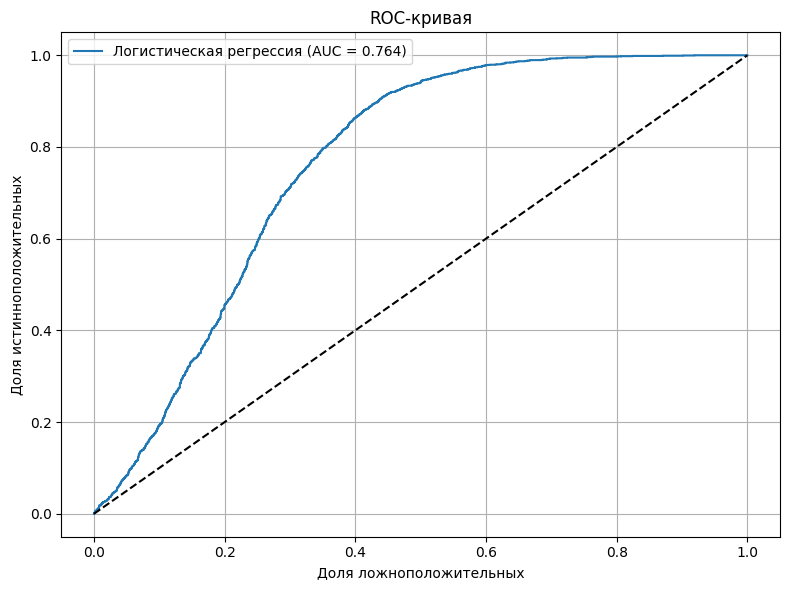

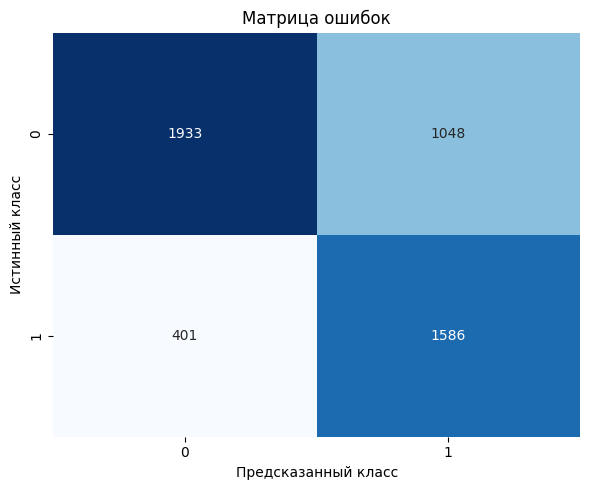

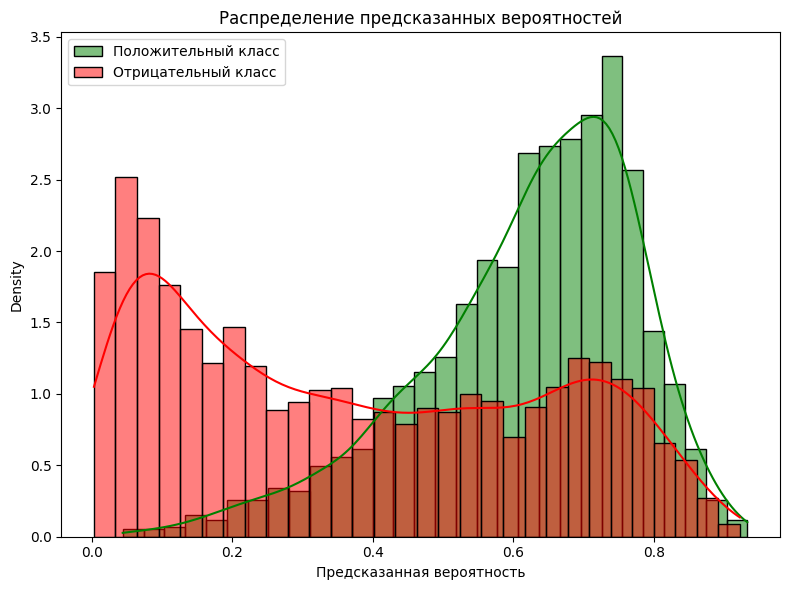

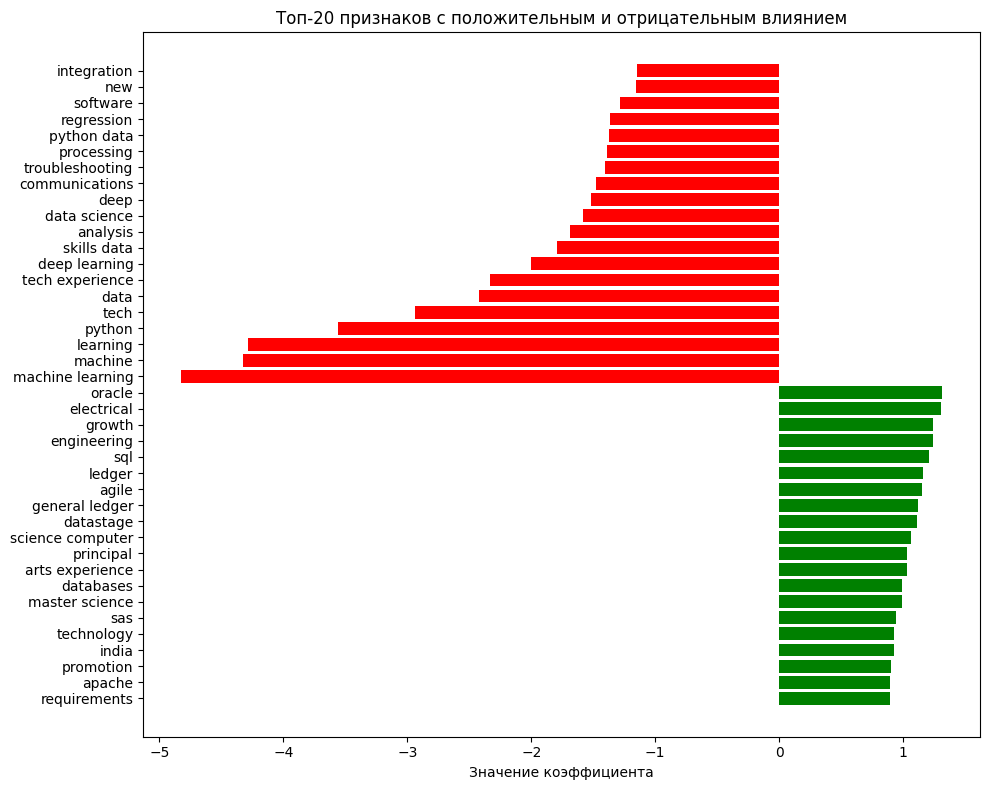

In [ ]:
# --- 4. Визуализация результатов ---

# 4.1 ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Логистическая регрессия (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинноположительных')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

# 4.2 Матрица ошибок (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 4.3 Распределение вероятностей предсказаний
plt.figure(figsize=(8,6))
sns.histplot(y_proba[y_test==1], color='g', label='Положительный класс', kde=True, stat='density', bins=30)
sns.histplot(y_proba[y_test==0], color='r', label='Отрицательный класс', kde=True, stat='density', bins=30)
plt.xlabel('Предсказанная вероятность')
plt.title('Распределение предсказанных вероятностей')
plt.legend()
plt.tight_layout()
plt.savefig('predicted_probabilities.png')
plt.show()

# 4.4 Важность признаков (топ-20)
feature_names = np.array(vectorizer.get_feature_names_out())
coef = model.coef_[0]
top_positive_idx = np.argsort(coef)[-20:]
top_negative_idx = np.argsort(coef)[:20]

plt.figure(figsize=(10,8))
plt.barh(feature_names[top_positive_idx], coef[top_positive_idx], color='green')
plt.barh(feature_names[top_negative_idx], coef[top_negative_idx], color='red')
plt.title('Топ-20 признаков с положительным и отрицательным влиянием')
plt.xlabel('Значение коэффициента')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


# Градиентный бустинг

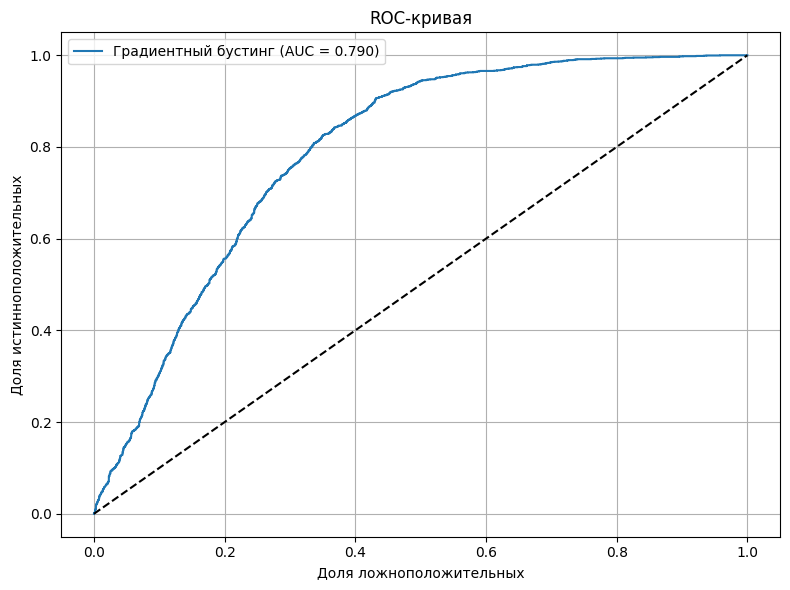

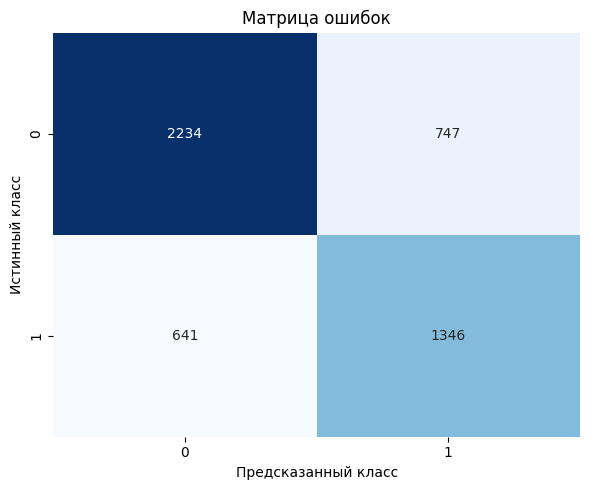

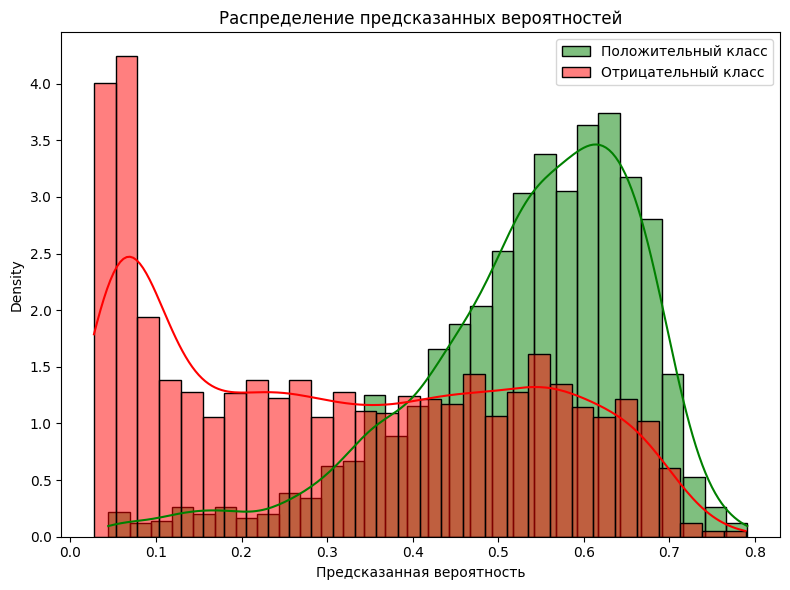

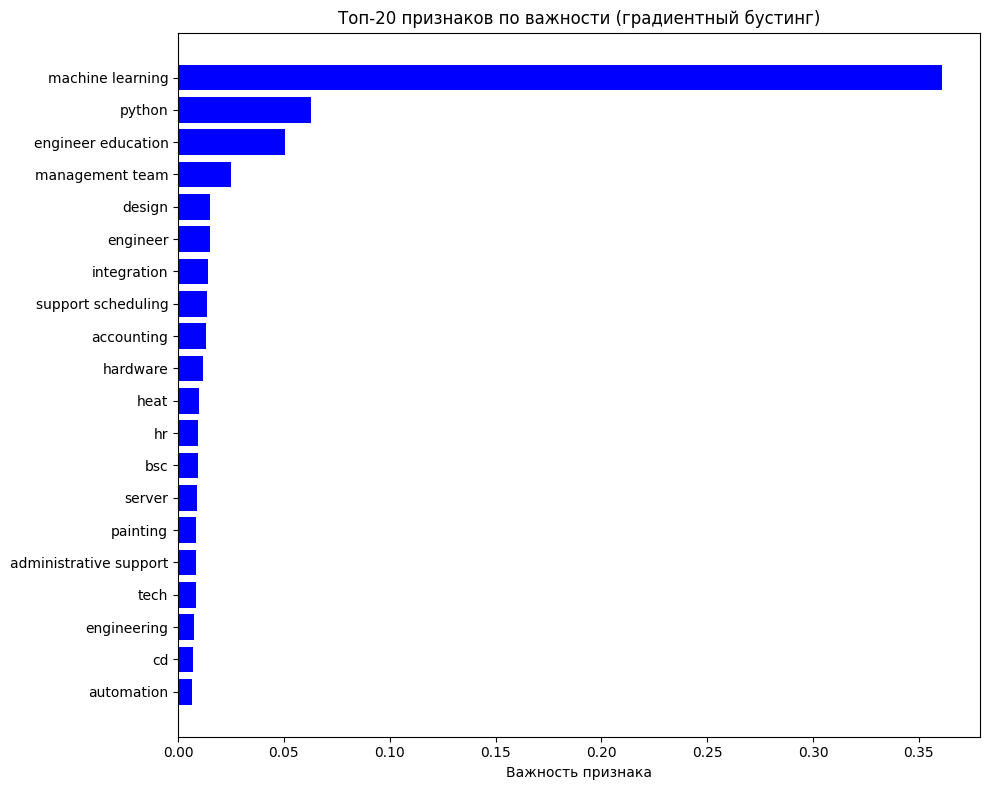

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Обучение модели градиентного бустинга
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_gb.fit(X_train_tfidf, y_train)

# Предсказания
y_pred_gb = model_gb.predict(X_test_tfidf)
y_proba_gb = model_gb.predict_proba(X_test_tfidf)[:, 1]
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

# --- Визуализация результатов ---

# 1. ROC-кривая
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(8,6))
plt.plot(fpr_gb, tpr_gb, label=f'Градиентный бустинг (AUC = {roc_auc_gb:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинноположительных')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve_gb.png')
plt.show()

# 2. Матрица ошибок
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.savefig('confusion_matrix_gb.png')
plt.show()

# 3. Распределение вероятностей предсказаний
plt.figure(figsize=(8,6))
sns.histplot(y_proba_gb[y_test==1], color='g', label='Положительный класс', kde=True, stat='density', bins=30)
sns.histplot(y_proba_gb[y_test==0], color='r', label='Отрицательный класс', kde=True, stat='density', bins=30)
plt.xlabel('Предсказанная вероятность')
plt.title('Распределение предсказанных вероятностей')
plt.legend()
plt.tight_layout()
plt.savefig('predicted_probabilities_gb.png')
plt.show()

# 4. Важность признаков (топ-20)
feature_names = np.array(vectorizer.get_feature_names_out())
importances = model_gb.feature_importances_
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10,8))
plt.barh(feature_names[top_idx], importances[top_idx], color='blue')
plt.title('Топ-20 признаков по важности (градиентный бустинг)')
plt.xlabel('Важность признака')
plt.tight_layout()
plt.savefig('feature_importance_gb.png')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Вычисление метрик качества
acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print("Метрики качества градиентного бустинга:")
print(f"Accuracy: {acc_gb:.4f}")
print(f"Precision: {prec_gb:.4f}")
print(f"Recall: {rec_gb:.4f}")
print(f"F1-score: {f1_gb:.4f}")
print(f"ROC AUC: {roc_auc_gb:.4f}")
print("\nОтчёт классификации:\n", classification_report(y_test, y_pred_gb))


Метрики качества градиентного бустинга:
Accuracy: 0.7206
Precision: 0.6431
Recall: 0.6774
F1-score: 0.6598
ROC AUC: 0.7902

Отчёт классификации:
               precision    recall  f1-score   support

         0.0       0.78      0.75      0.76      2981
         1.0       0.64      0.68      0.66      1987

    accuracy                           0.72      4968
   macro avg       0.71      0.71      0.71      4968
weighted avg       0.72      0.72      0.72      4968



# Случайный лес

Метрики качества случайного леса:
Accuracy: 0.7128
Precision: 0.6300
Recall: 0.6829
F1-score: 0.6554
ROC AUC: 0.7860

Отчёт классификации:
               precision    recall  f1-score   support

         0.0       0.78      0.73      0.75      2981
         1.0       0.63      0.68      0.66      1987

    accuracy                           0.71      4968
   macro avg       0.70      0.71      0.70      4968
weighted avg       0.72      0.71      0.71      4968



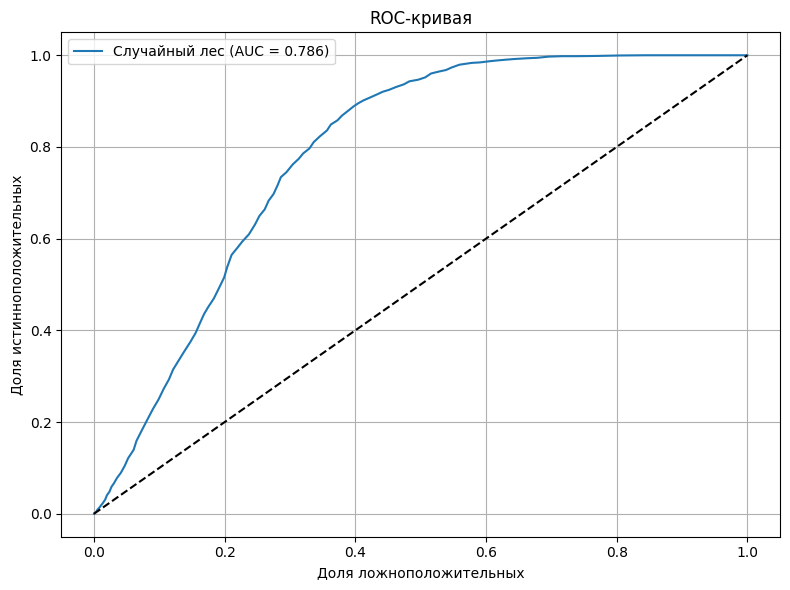

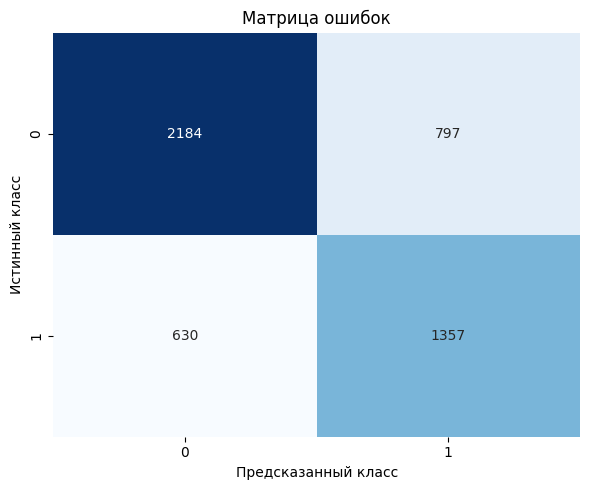

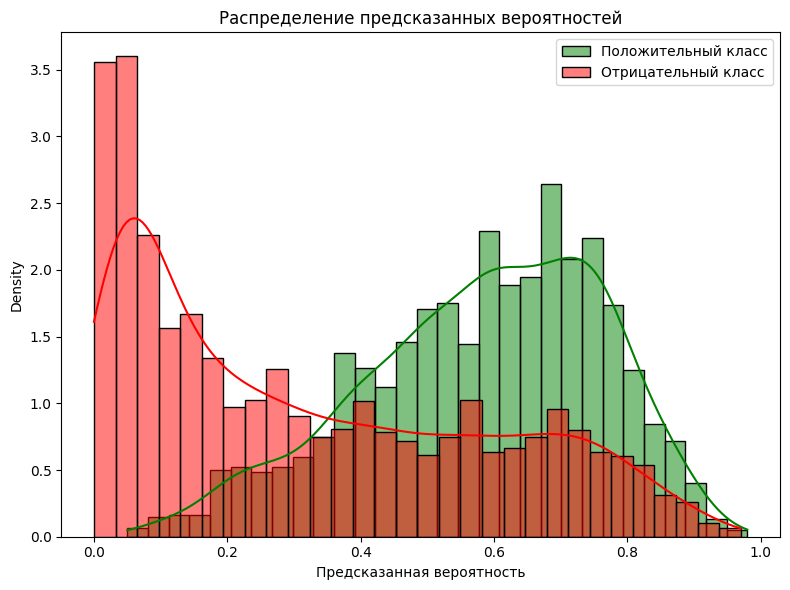

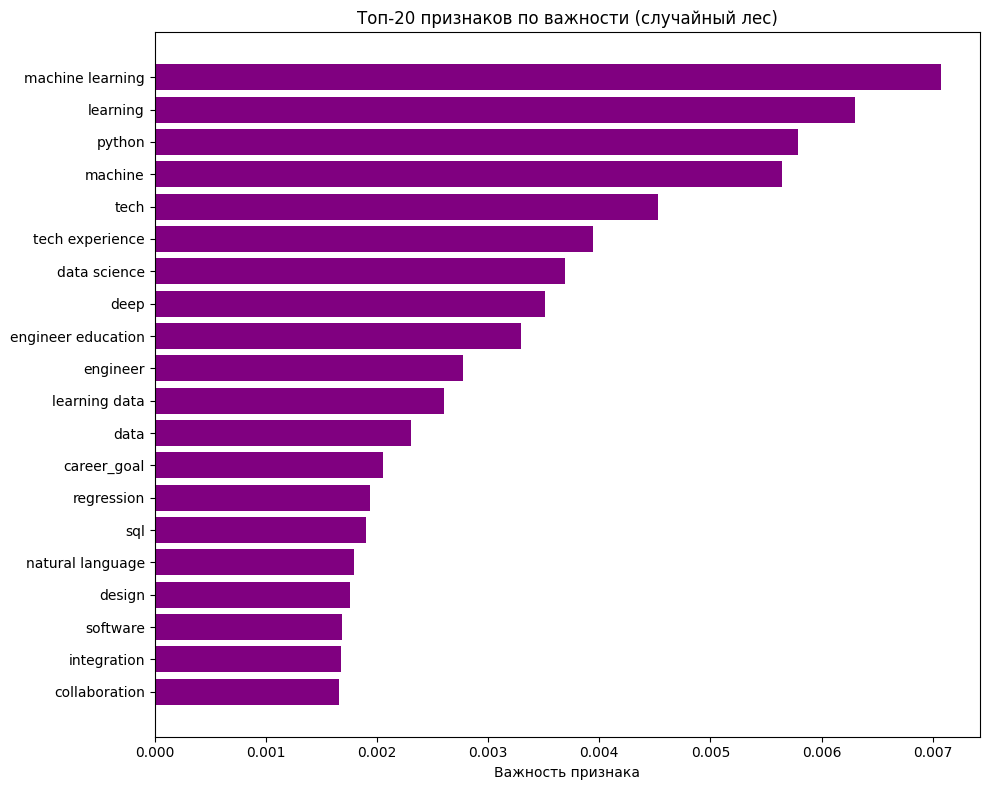

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Обучение модели случайного леса
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_rf.fit(X_train_tfidf, y_train)

# Предсказания
y_pred_rf = model_rf.predict(X_test_tfidf)
y_proba_rf = model_rf.predict_proba(X_test_tfidf)[:, 1]

# Вычисление метрик
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Метрики качества случайного леса:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print("\nОтчёт классификации:\n", classification_report(y_test, y_pred_rf))

# --- Визуализация результатов ---

# ROC-кривая
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Случайный лес (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинноположительных')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve_rf.png')
plt.show()

# Матрица ошибок
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png')
plt.show()

# Распределение вероятностей предсказаний
plt.figure(figsize=(8,6))
sns.histplot(y_proba_rf[y_test==1], color='g', label='Положительный класс', kde=True, stat='density', bins=30)
sns.histplot(y_proba_rf[y_test==0], color='r', label='Отрицательный класс', kde=True, stat='density', bins=30)
plt.xlabel('Предсказанная вероятность')
plt.title('Распределение предсказанных вероятностей')
plt.legend()
plt.tight_layout()
plt.savefig('predicted_probabilities_rf.png')
plt.show()

# Важность признаков (топ-20)
feature_names = np.array(vectorizer.get_feature_names_out())
importances = model_rf.feature_importances_
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10,8))
plt.barh(feature_names[top_idx], importances[top_idx], color='purple')
plt.title('Топ-20 признаков по важности (случайный лес)')
plt.xlabel('Важность признака')
plt.tight_layout()
plt.savefig('feature_importance_rf.png')
plt.show()


# Графики для нейросетей

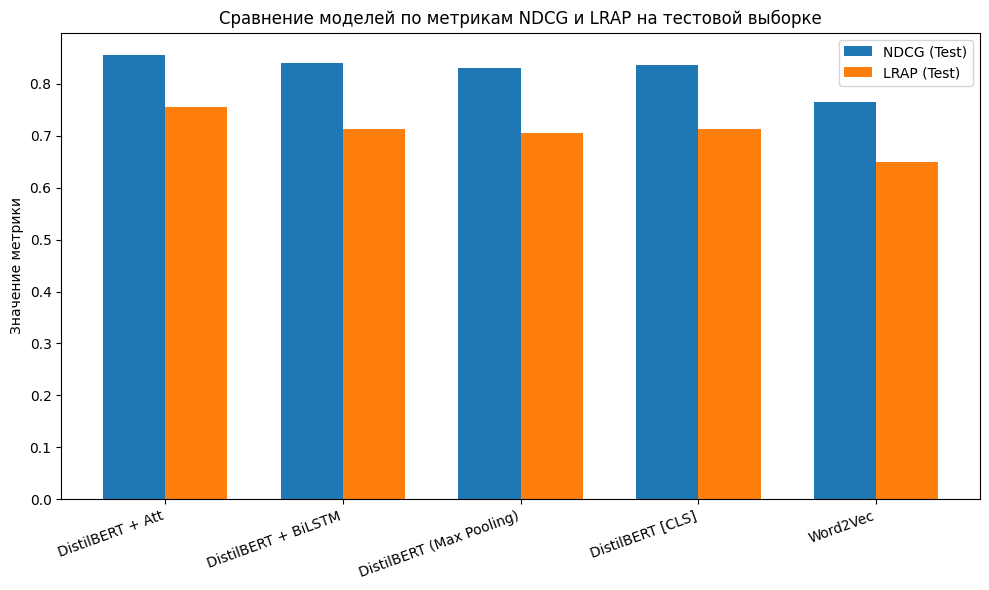

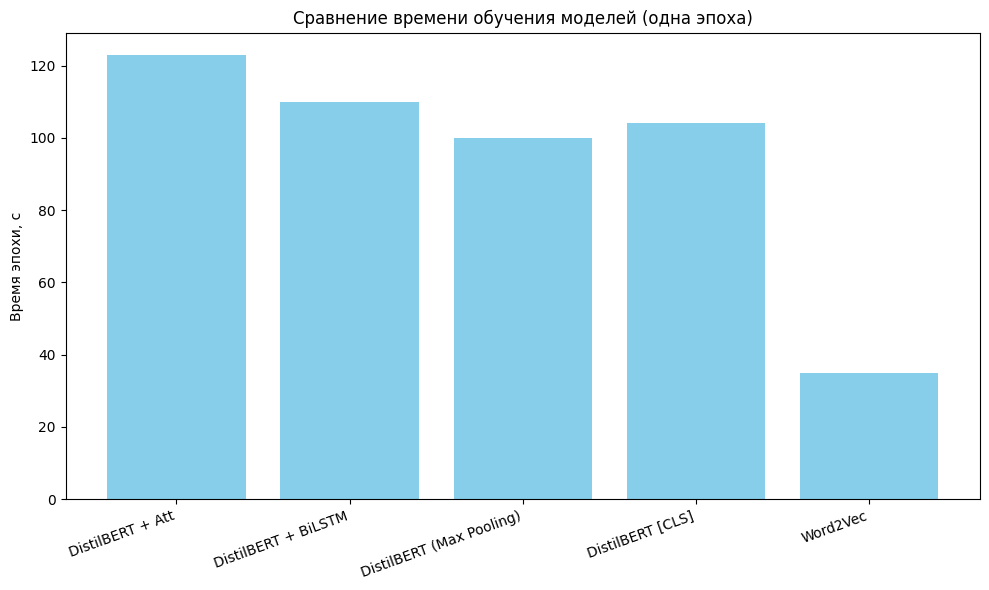

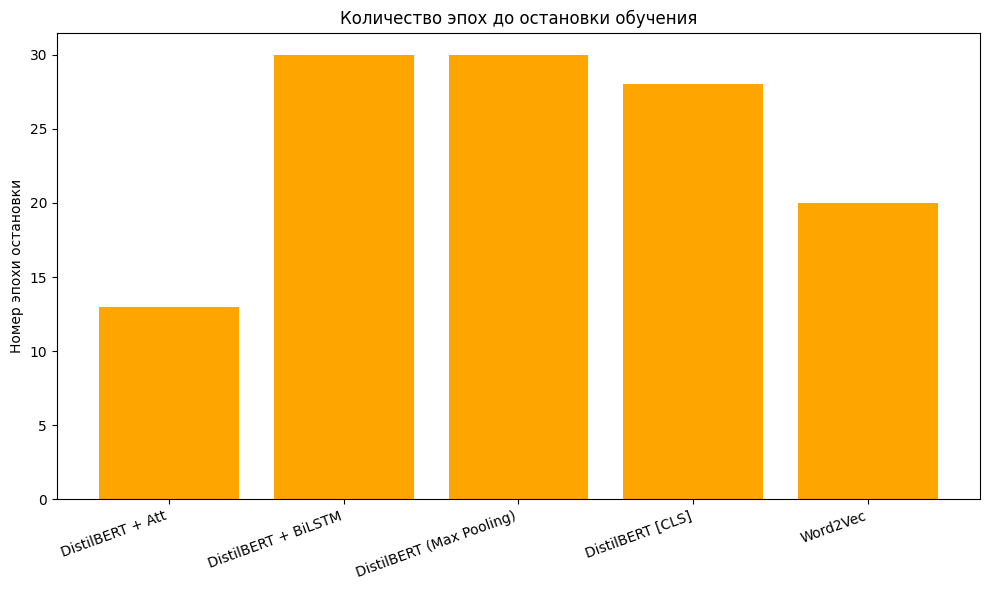

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные
models = [
    'DistilBERT + Att',
    'DistilBERT + BiLSTM',
    'DistilBERT (Max Pooling)',
    'DistilBERT [CLS]',
    'Word2Vec'
]

ndcg_test = [0.856, 0.840, 0.831, 0.837, 0.765]
lrap_test = [0.755, 0.714, 0.706, 0.713, 0.650]
epochs = [13, 30, 30, 28, 20]
epoch_time = [123, 110, 100, 104, 35]

df = pd.DataFrame({
    'Модель': models,
    'NDCG (Test)': ndcg_test,
    'LRAP (Test)': lrap_test,
    'Эпоха': epochs,
    'Время эпохи, с': epoch_time
})

# Визуализация NDCG и LRAP
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(models))

plt.bar(x - bar_width/2, df['NDCG (Test)'], width=bar_width, label='NDCG (Test)')
plt.bar(x + bar_width/2, df['LRAP (Test)'], width=bar_width, label='LRAP (Test)')
plt.xticks(x, models, rotation=20, ha='right')
plt.ylabel('Значение метрики')
plt.title('Сравнение моделей по метрикам NDCG и LRAP на тестовой выборке')
plt.legend()
plt.tight_layout()
plt.savefig('bert_models_metrics.png')
plt.show()

# Визуализация времени эпохи
plt.figure(figsize=(10, 6))
plt.bar(models, df['Время эпохи, с'], color='skyblue')
plt.ylabel('Время эпохи, с')
plt.title('Сравнение времени обучения моделей (одна эпоха)')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('bert_models_time.png')
plt.show()

# Визуализация количества эпох до остановки
plt.figure(figsize=(10, 6))
plt.bar(models, df['Эпоха'], color='orange')
plt.ylabel('Номер эпохи остановки')
plt.title('Количество эпох до остановки обучения')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('bert_models_epochs.png')
plt.show()
